# FareCast NYC: Empowering TLC Riders with Fare Estimation

## Overview

**Executive Summary:**

Automatidata, a fictional data consulting firm, is collaborating with the New York City Taxi and Limousine Commission (TLC). Since its establishment in 1971, the TLC has been responsible for regulating and overseeing the licensing of various transportation services in New York City, including taxi cabs, for-hire vehicles, commuter vans, and paratransit vehicles <sup>[1]</sup>. The TLC envisions the development of a user-friendly app, and in partnership with Automatidata, aims to enhance the overall experience for TLC riders by providing the ability to estimate taxi fares in advance.

This initiative aligns seamlessly with Automatidata's mission to transform untapped and stored data into practical solutions. Leveraging the extensive NYC TLC dataset, our goal is to craft a robust regression model that accurately estimates taxi fares, offering transparency and convenience to riders. The FareCast NYC app aspires to not only address the business needs of the TLC but also strategically impact the transportation landscape by improving transparency in fare calculations.

For more information about the TLC, visit their official page: [About TLC](https://www.nyc.gov/site/tlc/about/about-tlc.page).

**Project Objectives:**

1. Develop a robust fare estimation model:
    - Utilise historical data from the NYC TLC dataset to construct a reliable regression model for accurately estimating taxi fares.
    
    
2. Ensure accuracy and reliability:
    * Implement rigorous testing and optimization procedures to guarantee the precision and dependability of fare estimates generated by the model.


3. Create a user-friendly app interface:
    * Design an intuitive app interface tailored for TLC riders, facilitating easy and efficient estimation of taxi fares.


4. Enhance user satisfaction and confidence:
    * Improve overall user satisfaction and instil confidence in NYC taxi services by providing transparent and trustworthy fare estimation through the developed app.

**Data Sources:**

The primary data source for this project is the "2017 Yellow Taxi Trip Data", available on NYC OpenData. This dataset contains information on taxi and for-hire vehicle trips, with 22,699 rows and 18 columns.

For a detailed description of each attribute and its meaning, please refer to the [Data Dictionary](https://github.com/sssunri/farecast_NYC-TLC_estimation/blob/main/data_dictionary_trip_records_yellow.pdf) provided by the New York City Taxi & Limousine Commission. Leveraging this rich data dictionary, we will gain a comprehensive understanding of the dataset, which is crucial for building a robust fare estimation model.

## Data Exploration

**Load the Data**

In [1]:
# packages for numerics + dataframes
import pandas as pd
import numpy as np
from scipy import stats

pd.set_option('display.max_columns', None)

# packages for visualization
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['figure.figsize'] = 15, 5

# packages for OLS, MLR, confusion matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, roc_curve, RocCurveDisplay
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# function that helps plot feature importance 
from xgboost import plot_importance

# save your models and read them back in
from pathlib import Path
import pickle

In [2]:
# load dataset into dataframe
df = pd.read_csv('data/2017_Yellow_Taxi_Trip_Data.csv')

**Initial Exploration**

In [3]:
df.head()

,Unnamed: 0,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
0,24870114,2,03/25/2017 8:55:43 AM,03/25/2017 9:09:47 AM,6,3.34,1,N,100,231,1,13.0,0.0,0.5,2.76,0.0,0.3,16.56
1,35634249,1,04/11/2017 2:53:28 PM,04/11/2017 3:19:58 PM,1,1.80,1,N,186,43,1,16.0,0.0,0.5,4.00,0.0,0.3,20.80
2,106203690,1,12/15/2017 7:26:56 AM,12/15/2017 7:34:08 AM,1,1.00,1,N,262,236,1,6.5,0.0,0.5,1.45,0.0,0.3,8.75
3,38942136,2,05/07/2017 1:17:59 PM,05/07/2017 1:48:14 PM,1,3.70,1,N,188,97,1,20.5,0.0,0.5,6.39,0.0,0.3,27.69
4,30841670,2,04/15/2017 11:32:20 PM,04/15/2017 11:49:03 PM,1,4.37,1,N,4,112,2,16.5,0.5,0.5,0.00,0.0,0.3,17.80


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22699 entries, 0 to 22698
Data columns (total 18 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Unnamed: 0             22699 non-null  int64  
 1   VendorID               22699 non-null  int64  
 2   tpep_pickup_datetime   22699 non-null  object 
 3   tpep_dropoff_datetime  22699 non-null  object 
 4   passenger_count        22699 non-null  int64  
 5   trip_distance          22699 non-null  float64
 6   RatecodeID             22699 non-null  int64  
 7   store_and_fwd_flag     22699 non-null  object 
 8   PULocationID           22699 non-null  int64  
 9   DOLocationID           22699 non-null  int64  
 10  payment_type           22699 non-null  int64  
 11  fare_amount            22699 non-null  float64
 12  extra                  22699 non-null  float64
 13  mta_tax                22699 non-null  float64
 14  tip_amount             22699 non-null  float64
 15  to

The data types are generally appropriate for most columns. `tpep_pickup_datetime` and `tpep_dropoff_datetime` contain datetime information for the pickup and dropoff times. Converting these columns to `datetime` objects will facilitate the extraction of additional time-based features for future analysis and model training. This step ensures consistency and enables more straightforward date-based analysis.

All columns have non-null counts matching the total number of entries (22,699), indicating the absence of missing values. Several key attributes are likely to influence fare amounts, such as `trip_distance`, `passenger_count`, `payment_type`, and datetime features. The column `Unnamed: 0` appears to be redundant, possibly representing an old index. Removing it will enhance the clarity and efficiency of the dataset.

In [5]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,22699.0,5.675849e+07,3.274493e+07,12127.0,28520556.00,56731504.00,85374524.00,1.134863e+08
VendorID,22699.0,1.556236e+00,4.968384e-01,1.0,1.00,2.00,2.00,2.000000e+00
passenger_count,22699.0,1.642319e+00,1.285231e+00,0.0,1.00,1.00,2.00,6.000000e+00
trip_distance,22699.0,2.913313e+00,3.653171e+00,0.0,0.99,1.61,3.06,3.396000e+01
RatecodeID,22699.0,1.043394e+00,7.083909e-01,1.0,1.00,1.00,1.00,9.900000e+01
PULocationID,22699.0,1.624124e+02,6.663337e+01,1.0,114.00,162.00,233.00,2.650000e+02
DOLocationID,22699.0,1.615280e+02,7.013969e+01,1.0,112.00,162.00,233.00,2.650000e+02
payment_type,22699.0,1.336887e+00,4.962111e-01,1.0,1.00,1.00,2.00,4.000000e+00
fare_amount,22699.0,1.302663e+01,1.324379e+01,-120.0,6.50,9.50,14.50,9.999900e+02
extra,22699.0,3.332746e-01,4.630966e-01,-1.0,0.00,0.00,0.50,4.500000e+00


The descriptive statistics reveal a dataset with diverse numeric features exhibiting wide-ranging values, suggesting the importance of careful consideration during analysis. The majority of trips involve one to two passengers, occasionally reaching a maximum of six. Payments are predominantly made via credit card (payment type 1). The average trip distance is approximately 2.91 miles, and rate codes vary, with the majority falling under code 1. 

Notably, certain columns demonstrate considerable variability, potentially influencing specific analyses. For instance, the presence of a minimum passenger count of 0 prompts further investigation, as does the identification of negative values in `fare_amount`, demanding closer scrutiny. Additionally, related columns such as `tip_amount` and `total_amount` exhibit maximum values that appear as outliers. Recognizing the potential influence of outliers on statistical analyses, it is essential to subject them to further scrutiny. These findings underscore the need for a comprehensive exploratory data analysis (EDA) to gain a deeper understanding of the data distribution and identify and handle potential outliers effectively.

## Data Cleaning and Preprocessing

### Dealing with Duplicates

In [6]:
df.duplicated().sum()

0

The assessment for duplicate rows, conducted through df.duplicated().sum(), resulted in a count of 0, signifying the absence of duplicate entries in the dataset. This outcome reinforces the integrity of the data, affirming that each row distinctly represents a unique taxi trip. The absence of duplicates enhances the reliability of our analysis, providing a solid foundation for subsequent exploration and modeling efforts.

### Date and Time Parsing

The conversion of the date and time columns to `datetime` objects is performed to facilitate easier manipulation of temporal information. This transformation enables more straightforward analyses involving time-based features. Subsequently, we will extract pertinent temporal features, such as the day of the week or hour of the day, to deepen our understanding of the temporal patterns within the dataset. This step is pivotal for enhancing the model's ability to discern variations in taxi fares based on specific time-related factors, contributing to the overall robustness of our analytical approach.

In [7]:
df['tpep_pickup_datetime'] = pd.to_datetime(df['tpep_pickup_datetime'])
df['tpep_pickup_datetime'].head()

0   2017-03-25 08:55:43
1   2017-04-11 14:53:28
2   2017-12-15 07:26:56
3   2017-05-07 13:17:59
4   2017-04-15 23:32:20
Name: tpep_pickup_datetime, dtype: datetime64[ns]

In [8]:
df['tpep_dropoff_datetime'] = pd.to_datetime(df['tpep_dropoff_datetime'])
df['tpep_dropoff_datetime'].head()

0   2017-03-25 09:09:47
1   2017-04-11 15:19:58
2   2017-12-15 07:34:08
3   2017-05-07 13:48:14
4   2017-04-15 23:49:03
Name: tpep_dropoff_datetime, dtype: datetime64[ns]

### Handling Redundant Columns

The column labeled `Unnamed: 0` appears to be an index or identifier, and its role in the dataset is not explicitly defined. Given its potentially redundant nature, we will streamline the dataset by removing this column.

In [9]:
df.drop(columns='Unnamed: 0', inplace=True)

In [10]:
df['mta_tax'].value_counts()

 0.5    22596
 0.0       90
-0.5       13
Name: mta_tax, dtype: int64

The `mta_tax` column signifies a \\$0.50 MTA tax automatically triggered based on the metered rate in use. However, upon examining its distribution, we observe minimal variability, with the majority of values consistently set at \\$0.50. Given this limited variability and after careful consideration of its relevance to fare estimation, we have decided to remove the `mta_tax` column. The tax does not emerge as a critical factor in understanding or predicting fare amounts, and its presence may not significantly enhance the depth of our analysis.

In [11]:
df['improvement_surcharge'].value_counts()

 0.3    22679
-0.3       14
 0.0        6
Name: improvement_surcharge, dtype: int64

According to the data dictionary, the `improvement_surcharge` column denotes a \\$0.30 improvement surcharge assessed on trips at the flag drop, a practice initiated in 2015. However, upon examining its distribution, it becomes evident that the majority of values consistently remain at \\$0.30. With only a few instances of variation, the column's contribution to the analysis may be limited. Therefore, we have decided to remove the `improvement_surcharge` column as it is not deemed a critical factor in understanding or predicting fare amounts.

In [12]:
df.drop(columns=['mta_tax', 'improvement_surcharge'], inplace=True)

### Dealing with Outliers

Utilizing boxplots, we aim to gain a comprehensive understanding of the distribution of each feature within our dataset. These visualizations present a clear summary, showcasing key statistics such as the median, quartiles, and highlighting potential outliers. By visually inspecting the distribution of each variable, we can efficiently identify and assess the presence of any potential outliers, providing valuable insights for subsequent analysis and decision-making.

Given the relatively small size of our dataset, it is less likely that we will delete outliers. To address potential errors, our approach involves reassigning outliers by deriving new values to replace the outlier values. Alternatively, for the purpose of exploratory data analysis (without utilizing them in machine learning models), we will leave the outliers unchanged.

In [13]:
def boxplot(feature):
    sns.boxplot(data=df, x=feature)
    plt.title(f"Detect Outliers: {feature.title().replace('_', ' ')}")
    plt.show() 

In [14]:
def histplot(feature, **kwargs):
    sns.histplot(data=df, x=feature, **kwargs)
    plt.title(f"{feature.title().replace('_', ' ')}")
    plt.show()

**Trip Distance**

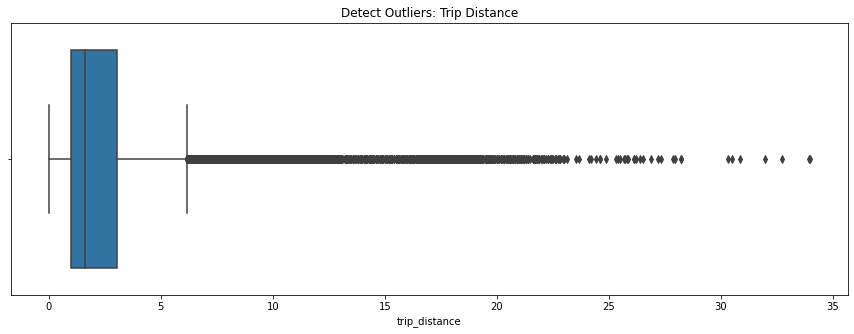

In [15]:
boxplot(feature='trip_distance')

The box plot analysis of trip distance reveals the presence of outliers; however, it is important to note that these outliers fall within a reasonable range for taxi trips in New York City, extending up to 35 miles. Given the nature of urban transportation in New York City, where taxi rides can cover varying distances, the observed outliers are considered normal and reflective of the diverse trip characteristics within the city. However, the analysis revealed some trips with a distance of zero, prompting further investigation into the smallest 10 unique trips.

In [16]:
set(df['trip_distance'].sort_values().unique()[:10])

{0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09}

In [17]:
(len(df[df['trip_distance'] == 0]) / len(df)) * 100

0.6520111018106525

The distances, captured with a high degree of precision, include values such as 0.01, 0.02, and so on. While it might seem unusual for trips to have distances of zero, this could be attributed to scenarios where a passenger summoned a taxi and subsequently changed their mind. Only a small percentage (<1%) of trips have zero miles traveled. Considering the negligible impact on the overall dataset, we have decided to retain these outliers in our analysis. This decision ensures that our data analysis accurately reflects the diverse characteristics of taxi trips in the city and provides a robust foundation for the FareCast NYC app's development.

**Fare Amount**

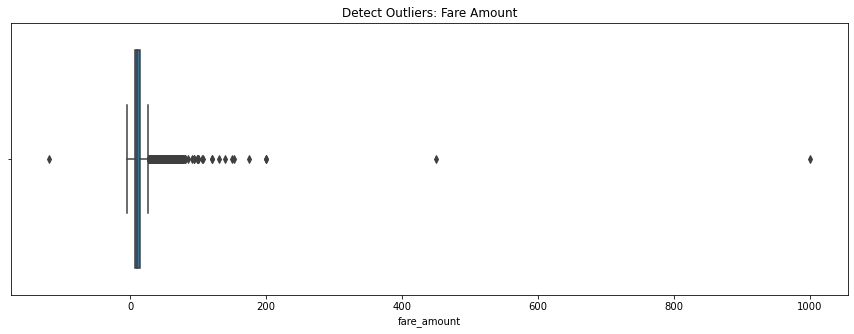

In [18]:
boxplot(feature='fare_amount')

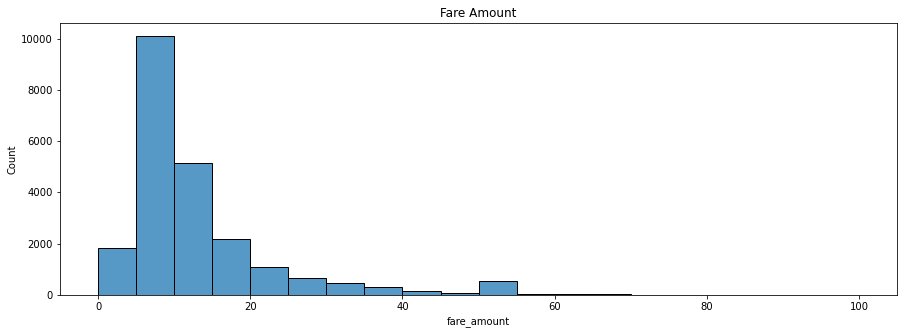

In [19]:
histplot(feature='fare_amount', bins=range(0, 101, 5))

In [20]:
df.describe()['fare_amount']

count    22699.000000
mean        13.026629
std         13.243791
min       -120.000000
25%          6.500000
50%          9.500000
75%         14.500000
max        999.990000
Name: fare_amount, dtype: float64

Analyzing the fare distribution histogram reveals a right-skewed distribution, with the majority of trip costs falling between \\$5 and \\$15. However, a detailed examination of total fare amounts identifies outliers that deviate significantly from this typical distribution. Notably, there are instances with a negative value of -\\$120 and extreme positive values, reaching as high as \\$1,000. These outliers, considered unusual, have the potential to introduce noise into our analysis.

Our commitment to providing transparent and accurate fare estimates through the FareCast NYC app necessitates the careful treatment of outliers. By addressing these extreme values, we aim to enhance the precision of our model and provide users with reliable fare estimates that align with the typical fare distribution observed in New York City taxi trips. This proactive approach ensures that the fare estimation process is robust and reflective of the expected fare amounts in the NYC transportation landscape.

In [21]:
q3 = df['fare_amount'].quantile(0.75)
iqr = q3 - df['fare_amount'].quantile(0.25)
iqr

8.0

In [22]:
upper_threshold = q3 + (1.5 * iqr)
upper_threshold

26.5

The interquartile range (IQR) for this feature was calculated, yielding a value of \\$8. However, the standard formula for outlier identification `(Q3 + 1.5 * IQR)` suggested a threshold of \\$26.50, which seemed inappropriate for a maximum fare cap. In this context, we opted for a more nuanced approach, using a factor of `6` to impute the upper-limit value. Additionally, any fare amounts less than \\$0 were imputed with 0 to maintain consistency.

In [23]:
def outlier_imputer(column_list, iqr_factor):
    '''
    Impute upper-limit values in specified columns based on their interquartile range.

    Arguments:
        column_list: A list of columns to iterate over
        iqr_factor: A number representing x in the formula:
                    Q3 + (x * IQR). Used to determine maximum threshold,
                    beyond which a point is considered an outlier.

    The IQR is computed for each column in column_list and values exceeding
    the upper threshold for each column are imputed with the upper threshold value.
    '''
    # reassign minimum to zero
    for i in column_list:
        df.loc[df[i] < 0, i] = 0

        # calculate upper threshold
        q3 = df[i].quantile(0.75)
        iqr = q3 - df[i].quantile(0.25)
        upper_threshold = q3 + (iqr_factor * iqr)

        # reassign values > threshold to threshold
        df.loc[df[i] > upper_threshold, i] = upper_threshold
        print(f'[{i}] q3: {q3}, upper threshold: {upper_threshold}')
        print(df[i].describe())

In [24]:
outlier_imputer(['fare_amount'], 6)

[fare_amount] q3: 14.5, upper threshold: 62.5
count    22699.000000
mean        12.897913
std         10.541137
min          0.000000
25%          6.500000
50%          9.500000
75%         14.500000
max         62.500000
Name: fare_amount, dtype: float64


The resulting `fare_amount` column underwent a transformation, with values exceeding the new upper threshold of \\$62.50 capped at this limit. This approach ensures a balanced treatment of extreme values, enhancing the reliability of our analysis. The impact of this imputation strategy is reflected in the updated statistics, where the maximum fare is now capped at \\$62.50, aligning with the characteristics of taxi fare distribution in New York City.

**Tip Amount**

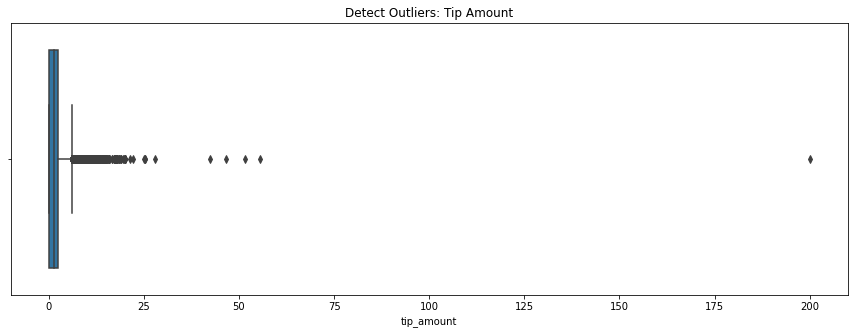

In [25]:
boxplot(feature='tip_amount')

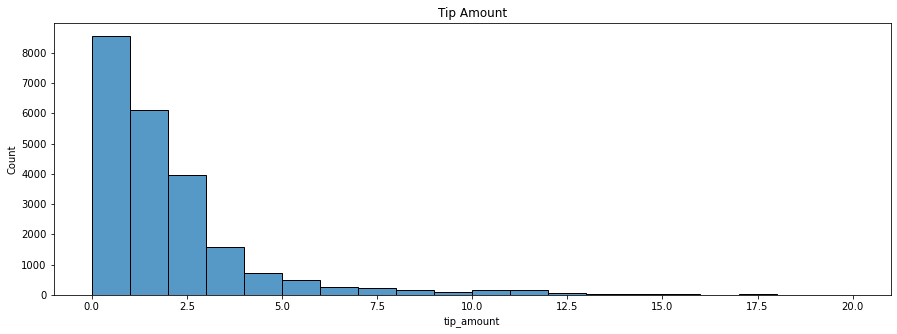

In [26]:
histplot(feature='tip_amount', bins=range(0, 21))

The distribution of tip amounts is right-skewed, with nearly all tips falling within the \\$0 to \\$3 range.

In [27]:
df.describe()['tip_amount']

count    22699.000000
mean         1.835781
std          2.800626
min          0.000000
25%          0.000000
50%          1.350000
75%          2.450000
max        200.000000
Name: tip_amount, dtype: float64

In [28]:
q3 = df['tip_amount'].quantile(0.75)
iqr = q3 - df['tip_amount'].quantile(0.25)
iqr

2.45

In [29]:
upper_threshold = q3 + (6 * iqr)
upper_threshold

17.150000000000002

In [30]:
outlier_imputer(['tip_amount'], 6)

[tip_amount] q3: 2.45, upper threshold: 17.150000000000002
count    22699.000000
mean         1.818543
std          2.374812
min          0.000000
25%          0.000000
50%          1.350000
75%          2.450000
max         17.150000
Name: tip_amount, dtype: float64


The `tip_amount` column exhibits a right-skewed distribution, as evident from its histogram, with the majority of tips falling within the \\$0 to \\$3 range. However, there are notable outliers, particularly in the range of \\$45 to \\$200, which deviate significantly from the typical distribution. To address this, we will apply a similar outlier imputation strategy as employed for the `fare_amount` column. The descriptive statistics reveal a mean tip amount of \\$1.83, with a standard deviation of \\$2.80, while the minimum and maximum values are \\$0 and \\$200, respectively. By calculating the interquartile range (IQR) and employing a factor of `6`, we determine a new upper threshold of \\$17.15. This approach ensures that extreme tip amounts are capped at a reasonable level, aligning with the expected distribution of tips in the context of taxi rides in New York City. 

## Feature Engineering

**Temporal Features**

In [31]:
# create a month column
df['month'] = df['tpep_pickup_datetime'].dt.month_name()
df['month'].head()

0       March
1       April
2    December
3         May
4       April
Name: month, dtype: object

In [32]:
# create a day of week column
df['day'] = df['tpep_pickup_datetime'].dt.day_name()
df['day'].head()

0    Saturday
1     Tuesday
2      Friday
3      Sunday
4    Saturday
Name: day, dtype: object

In [33]:
# create an hour column
df['hour'] = df['tpep_pickup_datetime'].dt.hour
df['hour'].head()

0     8
1    14
2     7
3    13
4    23
Name: hour, dtype: int64

**Time of Day**

We will introduce a `time_of_day` column, categorizing each trip based on the pickup time into specific periods:
- `am_rush`: 06:00 – 10:00
- `daytime`: 10:00 – 16:00
- `pm_rush`: 16:00 – 20:00
- `nighttime`: 20:00 – 06:00

In [34]:
df['time_of_day'] = df['hour'].copy()
for i in df['time_of_day']:
    if (i >= 6) & (i < 10):
        df['time_of_day'] = df['time_of_day'].replace(i, 'am_rush')
    elif (i >= 10) & (i < 16):
        df['time_of_day'] = df['time_of_day'].replace(i, 'daytime')
    elif (i >= 16) & (i < 20):
        df['time_of_day'] = df['time_of_day'].replace(i, 'pm_rush')
    else:
        df['time_of_day'] = df['time_of_day'].replace(i, 'nighttime')

In [35]:
df[['tpep_pickup_datetime', 'time_of_day']].head()

,tpep_pickup_datetime,time_of_day
0,2017-03-25 08:55:43,am_rush
1,2017-04-11 14:53:28,daytime
2,2017-12-15 07:26:56,am_rush
3,2017-05-07 13:17:59,daytime
4,2017-04-15 23:32:20,nighttime


**Transaction Season** 

We are introducing the `season` feature that categorizes each transaction based on the season in which it occurred. This addition will provide valuable insights into the temporal distribution of taxi trips, allowing for more nuanced analyses and predictions. This enhancement aims to capture seasonal patterns and variations in taxi usage, contributing to a more comprehensive understanding of the factors influencing fare amounts.

In [36]:
# https://stackoverflow.com/questions/44124436/python-datetime-to-season
# https://seasonsyear.com/USA/New-York/NYC  
df['season'] = df['tpep_pickup_datetime'].dt.month % 12 // 3 + 1
df[['season', 'month']]

,season,month
0,2,March
1,2,April
2,1,December
3,2,May
4,2,April
...,...,...
22694,1,February
22695,3,August
22696,4,September
22697,3,July


**Trip Duration**

In [37]:
# create duration column in minutes
df['duration'] = round((df['tpep_dropoff_datetime'] - df['tpep_pickup_datetime']) / np.timedelta64(1, 'm'), 2)
df['duration'].head()

0    14.07
1    26.50
2     7.20
3    30.25
4    16.72
Name: duration, dtype: float64

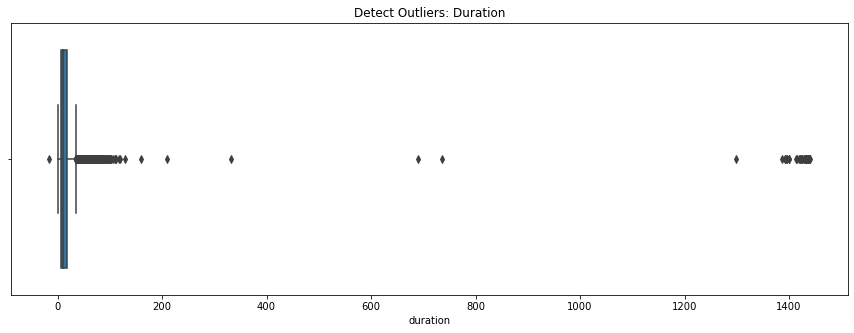

In [38]:
boxplot('duration')

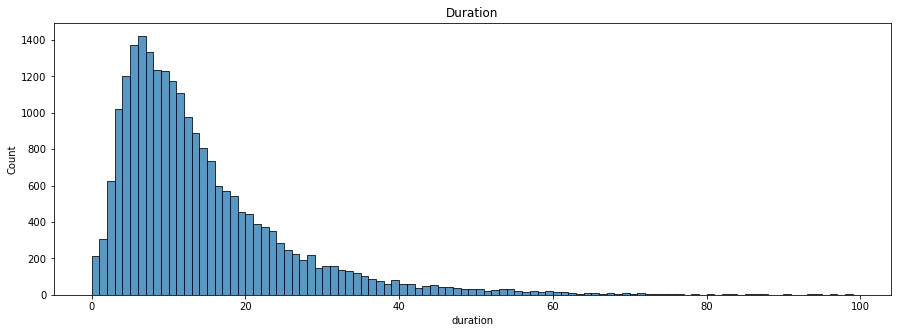

In [39]:
histplot(feature='duration', bins=range(0, 100))

In [40]:
df.describe()['duration']

count    22699.000000
mean        17.013766
std         61.996476
min        -16.980000
25%          6.650000
50%         11.180000
75%         18.380000
max       1439.550000
Name: duration, dtype: float64

In [41]:
outlier_imputer(['duration'], 6)

[duration] q3: 18.38, upper threshold: 88.75999999999999
count    22699.000000
mean        14.460471
std         11.946570
min          0.000000
25%          6.650000
50%         11.180000
75%         18.380000
max         88.760000
Name: duration, dtype: float64


The `duration` column, representing the duration of taxi trips, exhibits a right-skewed distribution, as observed from the histogram. The descriptive statistics highlight a mean duration of approximately 17 minutes, with a standard deviation of 61.99 minutes. However, an analysis of the boxplot reveals the presence of outliers, both below 0 and beyond 200 minutes. Outliers below 0 may be indicative of data entry errors, while extremely long durations could be attributed to specific circumstances or anomalies. To ensure the integrity of our analysis and provide users with realistic estimates, we will apply the outlier imputation strategy, determining new upper and lower thresholds for the `duration` column. This approach aims to cap extreme values, maintaining the overall accuracy of our analysis and aligning with the expected distribution of trip durations in the context of New York City taxi rides.

**Mean Trip Distance and Duration**

In anticipation of real-time predictions where the model will not have access to trip duration until after completion, we are proactively enhancing our dataset with new features. Specifically, we are introducing `mean_distance` and `mean_duration` based on pick-up and drop-off locations. These features leverage historical trip data to capture patterns and characteristics associated with specific areas. To begin, we will group and average trips that share a unique pair of start and end points together.

In [42]:
pickup, dropoff, pickup_dropoff = ([] for i in range(3))
for i in range(len(df)): 
    pickup.append(str(df['PULocationID'][i]))
    dropoff.append(str(df['DOLocationID'][i]))
    pickup_dropoff.append(f'{pickup[i]} {dropoff[i]}')
df['pickup_dropoff'] = pickup_dropoff
df['pickup_dropoff'].head()

0    100 231
1     186 43
2    262 236
3     188 97
4      4 112
Name: pickup_dropoff, dtype: object

**Mean Distance**

The `mean_distance` feature aggregates historical trip distances for each pick-up and drop-off location, offering valuable insights into the average distances travelers cover in those areas. This will enable our model to discern typical travel patterns and distances for different locations, enhancing its ability to predict future trips. 

In [43]:
# group unique pairs and aggregate trip distance average
grouped = df.groupby(by='pickup_dropoff').mean()[['trip_distance']]
grouped.head()

,trip_distance
pickup_dropoff,
1 1,2.433333
10 148,15.700000
100 1,16.890000
100 100,0.253333
100 107,1.180000


In [44]:
grouped_dict = grouped.to_dict()
for k, v in grouped_dict.items():
    grouped_dict = v

In [45]:
df['mean_distance'] = df['pickup_dropoff'].copy()
df['mean_distance'] = df['mean_distance'].map(grouped_dict)

# confirm that it worked
df[(df['PULocationID'] == 100) & (df['DOLocationID'] == 231)][['mean_distance']]

,mean_distance
0,3.521667
4909,3.521667
16636,3.521667
18134,3.521667
19761,3.521667
20581,3.521667


**Mean Duration**

The `mean_duration` feature calculates the average duration of trips originating from each pick-up and drop-off location. This metric provides a nuanced understanding of the typical time taken for journeys in specific areas.

In [46]:
grouped = df.groupby(by='pickup_dropoff').mean()[['duration']]
grouped_dict = grouped.to_dict()
for k , v in grouped_dict.items():
    grouped_dict = v
    
df['mean_duration'] = df['pickup_dropoff'].copy()
df['mean_duration'] = df['mean_duration'].map(grouped_dict)

# confirm that it worked
df[(df['PULocationID'] == 100) & (df['DOLocationID'] == 231)][['mean_duration']]

,mean_duration
0,22.848333
4909,22.848333
16636,22.848333
18134,22.848333
19761,22.848333
20581,22.848333


**Tip Percentage**

The introduction of the `tip_percent` column adds a valuable dimension to our dataset, representing the tip amount as a percentage of the total fare. This feature offers a nuanced perspective on passenger tipping behavior, allowing us to explore how tipping patterns vary relative to the overall trip cost. By examining these tipping percentages, we gain insights into potential influencing factors, contributing to a more comprehensive understanding of passenger behavior in tipping scenarios.

In [47]:
df['tip_percent'] = round(df['tip_amount'] / (df['total_amount'] - df['tip_amount']), 3)
df['tip_percent'].head()

0    0.200
1    0.238
2    0.199
3    0.300
4    0.000
Name: tip_percent, dtype: float64

In [48]:
df[df['tip_percent'].isna()]['tip_percent']

4402    NaN
5722    NaN
10506   NaN
22566   NaN
Name: tip_percent, dtype: float64

In [49]:
df['tip_percent'].fillna(0, inplace=True)

**Speed of the Trip**

In [50]:
df['trip_speed_mph'] = df['trip_distance'] / df['duration'] * 60
df['trip_speed_mph'].head()

0    14.243070
1     4.075472
2     8.333333
3     7.338843
4    15.681818
Name: trip_speed_mph, dtype: float64

In [51]:
df.describe()['trip_speed_mph']

count    2.267300e+04
mean              inf
std               NaN
min      0.000000e+00
25%      7.252747e+00
50%      9.843750e+00
75%      1.360714e+01
max               inf
Name: trip_speed_mph, dtype: float64

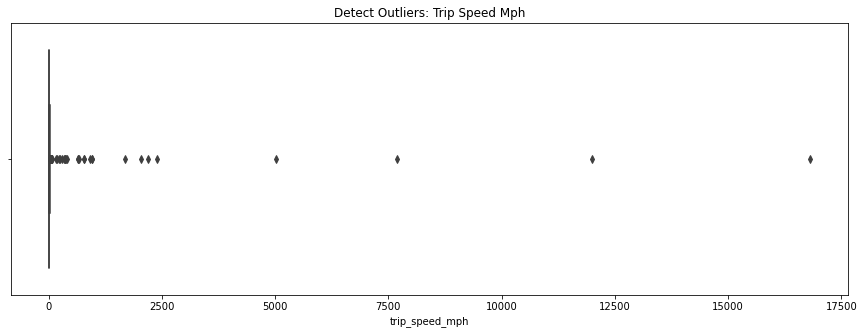

In [52]:
boxplot('trip_speed_mph')

In [53]:
df[df['trip_speed_mph'] > 65]

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,tip_amount,tolls_amount,total_amount,month,day,hour,time_of_day,season,duration,pickup_dropoff,mean_distance,mean_duration,tip_percent,trip_speed_mph
1075,1,2017-04-12 20:51:58,2017-04-12 20:52:07,1,2.30,1,N,265,265,3,2.5,0.5,0.00,0.00,3.80,April,Wednesday,20,nighttime,2,0.15,265 265,0.753077,3.411538,0.000,9.200000e+02
2223,1,2017-12-17 20:35:28,2017-12-17 20:35:31,1,10.00,1,N,132,132,3,2.5,0.5,0.00,0.00,3.80,December,Sunday,20,nighttime,1,0.05,132 132,2.255862,3.022414,0.000,1.200000e+04
3551,1,2017-11-11 19:33:32,2017-11-11 19:33:47,1,1.50,1,N,233,233,1,15.0,0.0,1.00,0.00,16.80,November,Saturday,19,pm_rush,4,0.25,233 233,0.558571,3.802857,0.063,3.600000e+02
3582,1,2017-01-01 23:53:01,2017-01-01 23:53:42,1,7.30,5,N,1,1,1,62.5,0.0,0.00,0.00,152.30,January,Sunday,23,nighttime,1,0.68,1 1,2.433333,0.463333,0.000,6.441176e+02
3734,1,2017-02-20 16:58:03,2017-02-20 16:58:15,1,0.60,1,N,265,265,3,2.5,0.0,0.00,0.00,3.30,February,Monday,16,pm_rush,1,0.20,265 265,0.753077,3.411538,0.000,1.800000e+02
4319,1,2017-01-28 12:30:33,2017-01-28 12:31:38,1,1.30,1,N,249,249,3,3.0,0.0,0.00,0.00,3.80,January,Saturday,12,daytime,1,1.08,249 249,0.410000,2.556667,0.000,7.222222e+01
5678,1,2017-06-11 04:31:36,2017-06-11 04:31:51,1,1.50,1,N,162,170,2,2.5,0.5,0.00,0.00,3.80,June,Sunday,4,nighttime,3,0.25,162 170,0.804792,5.778542,0.000,3.600000e+02
6501,1,2017-01-22 04:35:37,2017-01-22 04:35:45,1,1.70,2,N,113,113,3,52.0,0.0,0.00,0.00,52.80,January,Sunday,4,nighttime,1,0.13,113 113,0.834615,5.344615,0.000,7.846154e+02
6708,2,2017-10-30 11:23:46,2017-10-30 11:23:49,1,0.32,5,N,264,83,1,62.5,0.0,17.15,0.00,126.00,October,Monday,11,daytime,4,0.05,264 83,0.320000,0.050000,0.158,3.840000e+02
7167,2,2017-03-07 16:42:46,2017-03-07 16:42:48,1,0.20,2,N,264,132,1,52.0,4.5,17.15,0.00,74.49,March,Tuesday,16,pm_rush,2,0.03,264 132,0.066667,0.093333,0.299,4.000000e+02


Based on my [research](https://ekjlaw.com/speed-limits-in-new-york-how-much-over-the-speed-limit-is-too-much/#:~:text=Residential%20Areas%3A%20Usually%2030%20MPH,30%20MPH%20in%20most%20cases.), the maximum speed limit for vehicles in New York City is set at 65 MPH. Upon visual inspection of the boxplot depicting trip speeds, it became evident that there are several instances where the recorded speeds surpass this established limit. Upon further scrutiny, it was observed that these high-speed trips typically span within a very short duration, approximately 2 minutes. Given that these entries deviate significantly from the expected norms and may indicate errors or anomalies in the data, a decision has been made to remove these specific entries from our dataset.

In [54]:
df = df[df['trip_speed_mph'] <= 65]

## Exploratory Data Analysis (EDA)

### Fare Analysis

**Fare Distribution**

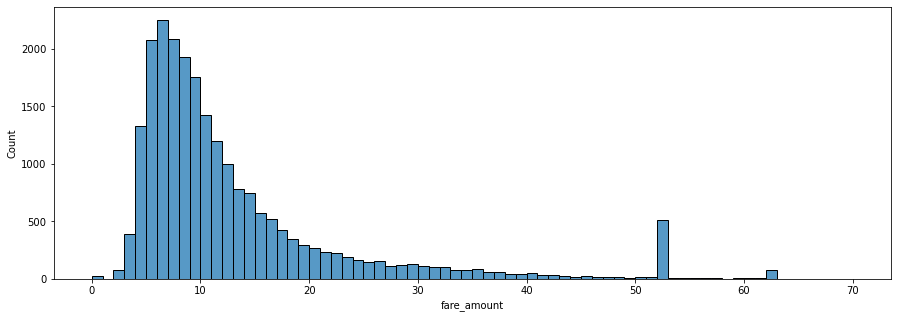

In [55]:
sns.histplot(data=df, x='fare_amount', bins=range(0, 71))
plt.show()

The histogram visually represents the diverse range of fare values, providing valuable insights into the pricing structure of taxi trips in New York City. The majority of taxi fares fall within the range of \\$6.0 to \\$9.5, reflecting common pricing for standard trips. The right-skewed distribution indicates that most fares are concentrated towards the lower end of the scale, with a tail extending towards higher fare values. Occasional higher fares, attributed to factors like longer distances or additional services, contribute to the rightward skewness. 

### Payment Type Insights

**Distribution of Payment Types in NYC Taxi Trips**

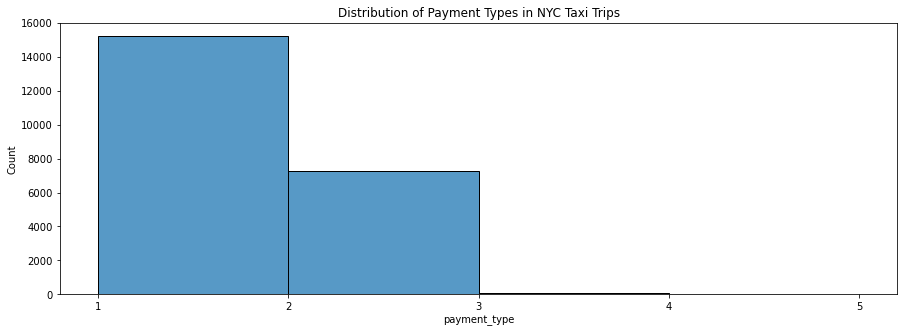

In [56]:
ax = sns.histplot(data=df, x='payment_type', bins=range(1, 6))
plt.title('Distribution of Payment Types in NYC Taxi Trips')
ax.set_xticks(range(1, 6))
plt.show()

The distribution of payment types in NYC taxi trips reveals that credit card payments (payment type 1) are the most common, while cash payments (payment type 2) are also prevalent. In contrast, transactions with no charge (payment type 3) are relatively infrequent. These findings offer a snapshot of the predominant modes of payment in NYC taxi trips, emphasizing the prevalence of credit card and cash transactions.

In [57]:
# what is the average tip for trips paid for with credit card?
credit_avg_tip = df[df['payment_type'] == 1].mean(numeric_only=True)['tip_amount']
print(f'credit card average tip: ${credit_avg_tip:.2f}')

# what is the average tip for trips paid for with cash?
cash_avg_tip = df[df['payment_type'] == 2].mean(numeric_only=True)['tip_amount']
print(f'cash average tip: ${cash_avg_tip}')

credit card average tip: $2.70
cash average tip: $0.0


The analysis of average tips for NYC taxi trips reveals interesting insights based on payment methods. Trips paid with credit cards, on average, receive a tip of \\$2.70. In contrast, cash payments show an average tip of \\$0.00. This discrepancy may suggest a notable difference in tipping behavior between credit card and cash transactions. Further investigation into the factors influencing tipping patterns could provide valuable insights into customer preferences and behaviors in the context of taxi payments.

**Fare Distribution Proportion by Payment Type**

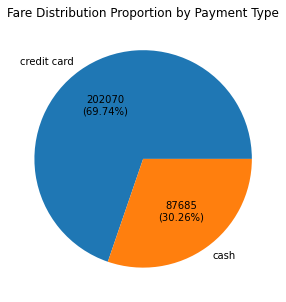

In [58]:
fare_by_payment = df.groupby(by='payment_type').sum()[['fare_amount']][:2]
plt.pie(data=fare_by_payment, x='fare_amount', labels=['credit card', 'cash'], autopct=lambda p: '{:.0f}\n({:.2f}%)'.format(p * sum(fare_by_payment['fare_amount']) / 100, p))
plt.title('Fare Distribution Proportion by Payment Type')
plt.show()

The analysis of fare distribution by payment type reveals distinct patterns in the total fare amounts associated with credit card (payment type 1) and cash (payment type 2) transactions. Credit card payments contribute a significantly higher total fare amount, compared to cash payments. This disparity suggests a clear preference for credit card transactions among taxi users. The prevalence of credit card payments reflects the convenience and efficiency that credit card transactions offer. Faster transactions and the observed higher tip amounts (as discussed previously) make credit card payments an attractive choice for both passengers and drivers. Understanding these payment dynamics is crucial for strategic decision-making, particularly in optimizing payment processing systems and devising effective promotional strategies.

### Comparisons Across Vendors

In [59]:
# how many times is each vendor ID represented in the data?
df['VendorID'].value_counts()

2    12621
1    10023
Name: VendorID, dtype: int64

In [60]:
# what is the mean total amount for each vendor?
df.groupby(by='VendorID').mean()[['total_amount']]

,total_amount
VendorID,
1,16.160302
2,16.298975


Both Vendor ID 1 and Vendor ID 2 are well-represented, with the latter being more prevalent. Additionally, the mean total amount for each vendor is comparable. These findings provide an overview of the distribution of trips among different vendors and suggest a similar average total amount between the two vendors.

**Tip Amount by Vendor**

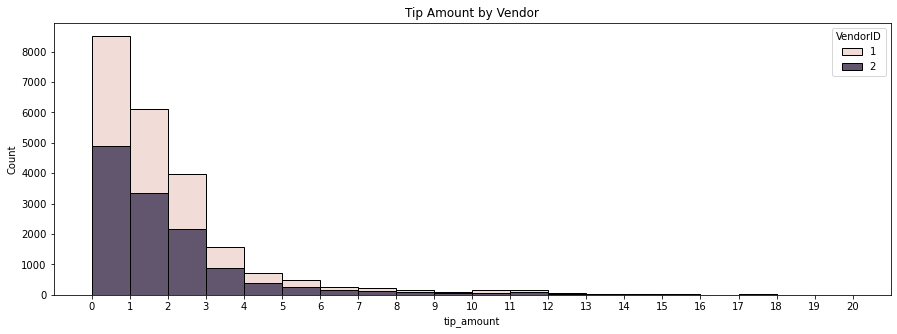

In [61]:
ax = sns.histplot(data=df, x='tip_amount', hue='VendorID', bins=range(0, 21), multiple='stack')
ax.set_xticks(range(0, 21))
plt.title('Tip Amount by Vendor')
plt.show()

Examining the tip amount distribution by vendor shows no noticeable aberrations between the two vendors in the dataset. Vendor ID 2 has a slightly higher share of the rides, and this proportion is approximately maintained across all tip amounts.

**Tip Amount by Vendor for Tips over \\$10**

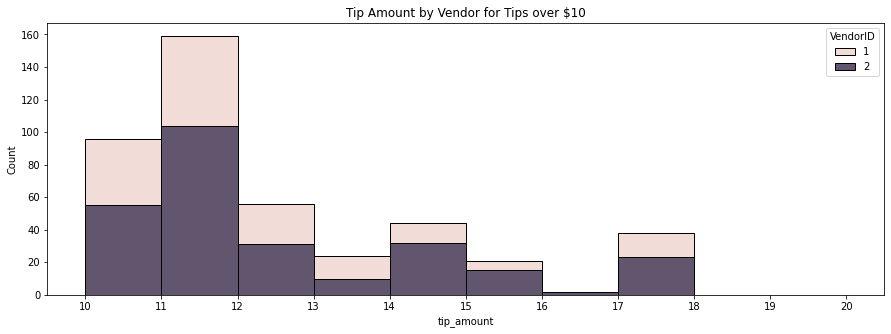

In [62]:
tips_over_10 = df[df['tip_amount'] > 10]
ax = sns.histplot(data=tips_over_10, x='tip_amount', hue='VendorID', bins=range(10, 21), multiple='stack')
ax.set_xticks(range(10, 21))
plt.title('Tip Amount by Vendor for Tips over $10')
plt.show()

Upon closer examination of the upper end of the tip range, the same proportions are maintained, with Vendor ID 2 consistently having a higher share than Vendor ID 1. Vendor ID 2 appears to be more popular in the dataset, as it is more prevalent in terms of the number of rides. The distribution of tip amounts also suggests a consistent higher share for Vendor ID 2 across various tip ranges. While both vendors show comparable mean total amounts, the consistently higher proportion of rides for Vendor ID 2 implies a higher popularity within the dataset.

### Passenger Count Influence

In [63]:
df['passenger_count'].value_counts()

1    16069
2     3302
5     1143
3      951
6      693
4      454
0       32
Name: passenger_count, dtype: int64

This breakdown offers insights into the composition of groups utilizing taxi services. The majority of trips involve a single passenger, accounting for nearly two-thirds of all rides. Although less common, multiple-passenger trips contribute to the overall distribution, with nearly 700 rides accommodating as many as six passengers. However, it is worth noting that there are 33 rides with an occupancy count of zero, which appears to be anomalous and requires further investigation.

**Mean Tips by Passenger Count**

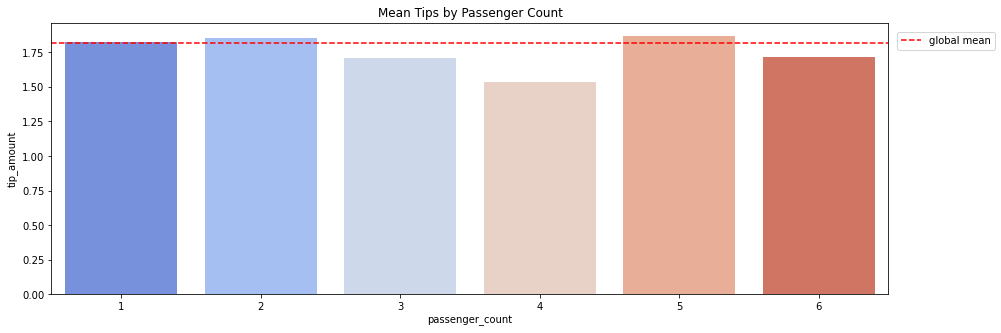

In [64]:
tips_by_passenger = df.groupby(by='passenger_count').mean()[['tip_amount']]
tips_by_passenger = tips_by_passenger[1:]
ax = sns.barplot(data=tips_by_passenger, x=tips_by_passenger.index, y='tip_amount', palette='coolwarm')
ax.axhline(df['tip_amount'].mean(), ls='--', color='red', label='global mean')
ax.legend(loc=(1.01, 0.9))
plt.title('Mean Tips by Passenger Count')
plt.show()

The barplot offers insights into the average tip amounts for different-sized groups of passengers. These averages suggest that, on average, passengers tend to provide similar tip amounts regardless of the number of occupants in the taxi. The slight variations observed may be influenced by factors such as trip duration, distance, or overall satisfaction with the service. Although there is a noticeable drop for four-passenger rides, this is expected due to the lower frequency of such rides in the dataset.

**Mean Fare Amount by Passenger Count**

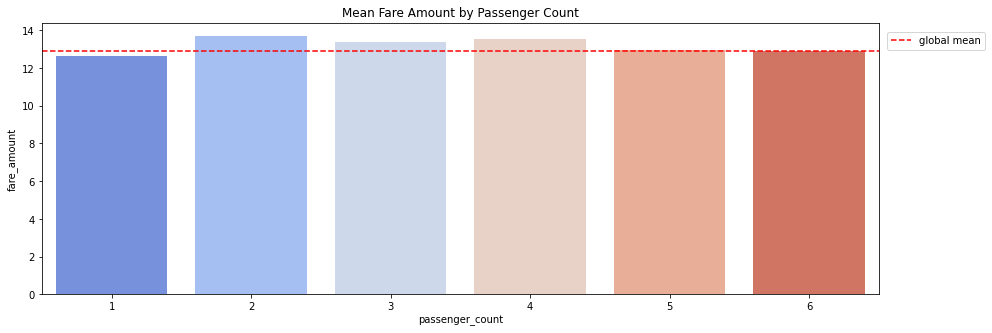

In [65]:
fare_by_passenger = df.groupby(by='passenger_count').mean()[['fare_amount']]
fare_by_passenger = fare_by_passenger[1:]
ax = sns.barplot(data=fare_by_passenger, x=fare_by_passenger.index, y='fare_amount', palette='coolwarm')
ax.axhline(df['fare_amount'].mean(), ls='--', color='red', label='global mean')
ax.legend(loc=(1.01, 0.9))
plt.title('Mean Fare Amount by Passenger Count')
plt.show()

The analysis of fare amounts based on passenger count reveals interesting patterns. Trips with two to four passengers exhibit higher average fares, while those with one passenger tend to have the lowest fares. This pattern suggests a potential correlation between passenger count and fare amounts, where trips with more passengers may involve longer distances or different trip characteristics, impacting the fare. In the FareCast NYC application, users can enhance their experience by inputting the number of passengers, allowing for more accurate fare estimates. This interactive feature not only engages users but also tailors the fare estimation process to their specific trip details. The data covers passenger counts ranging from one to six, and the application's consideration of passenger count will be integral to the accuracy of fare predictions.

**Tip Ratio by Passenger Count**

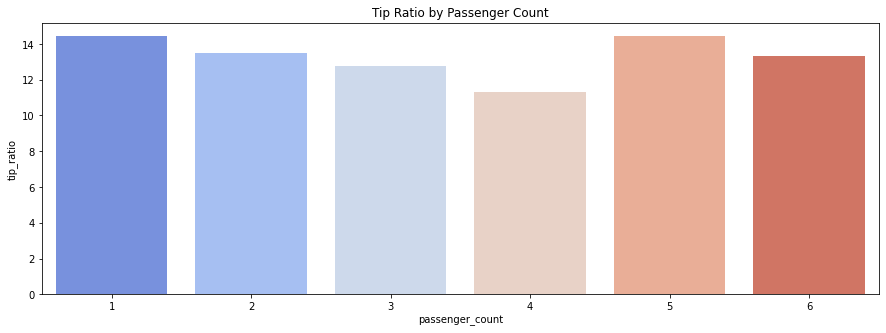

In [66]:
tip_bhvr = df.groupby(by='passenger_count').sum()[['fare_amount', 'tip_amount']][1:]
tip_bhvr['tip_ratio'] = (tip_bhvr['tip_amount'] / tip_bhvr['fare_amount']) * 100
sns.barplot(data=tip_bhvr, x=tip_bhvr.index, y='tip_ratio', palette='coolwarm')
plt.title('Tip Ratio by Passenger Count')
plt.show()

The bar heights in the chart illustrate the tip-to-fare ratio for each passenger count category. Transactions involving one, two, and five passengers exhibit higher tip ratios, indicating a tendency for passengers in these groups to tip a larger percentage of the fare amount. Conversely, passenger counts three, four, and six show slightly lower tip ratios, suggesting a relatively consistent tipping behavior within these groups.

While there is not a clear upward or downward trend in tip ratios with increasing or decreasing passenger counts, this analysis highlights the importance of considering tailored service strategies or incentive programs. Specifically, there may be opportunities to encourage higher tip ratios, particularly for passenger counts where tipping percentages are comparatively lower. This strategic approach could enhance overall customer satisfaction and contribute to increased tips for taxi services.

**Time and Distance Patterns by Passenger Count**

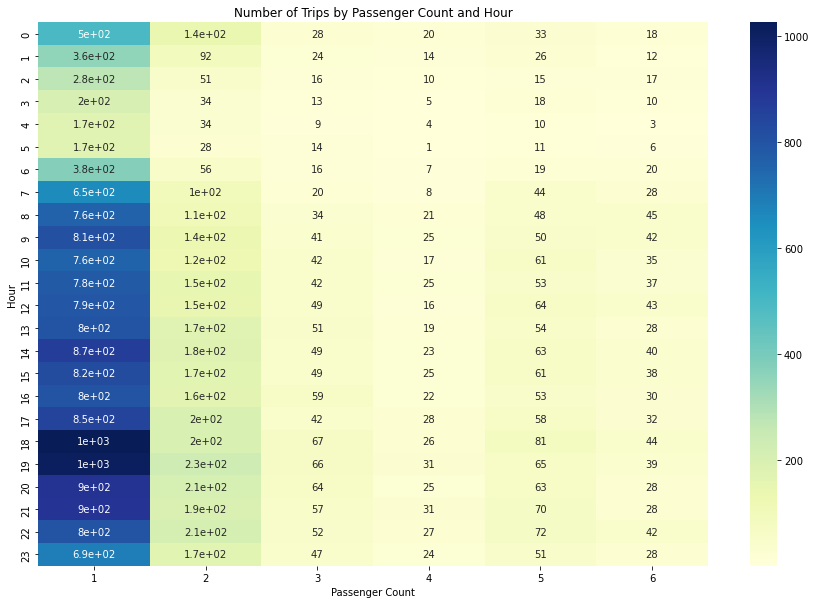

In [67]:
plt.figure(figsize=(15, 10))
passenger_count_per_hour = df[df['passenger_count'] >= 1]
heatmap_data = passenger_count_per_hour.groupby(by=['passenger_count', 'hour']).count()[['tpep_pickup_datetime']].reset_index().pivot(index='hour', columns='passenger_count', values='tpep_pickup_datetime')
sns.heatmap(heatmap_data, cmap='YlGnBu', annot=True)
plt.title('Number of Trips by Passenger Count and Hour')
plt.xlabel('Passenger Count')
plt.ylabel('Hour')
plt.show()

In examining the heatmap representing the frequency of taxi trips by both passenger count and hour, distinct patterns emerge, revealing the temporal dynamics of demand. The deeper blue hues, indicating higher intensities, underscore the prevalence of single-passenger and two-passenger trips, particularly evident from 7 AM onwards. Notably, the period between 5:30 PM and 7:30 PM emerges as a peak demand window, dominated by single-passenger rides, suggestive of the post-work commute. The sustained demand for two-passenger rides extends until 10 PM, hinting at ongoing commuting patterns and potential evening activities. These findings present actionable insights for taxi service providers, highlighting the strategic importance of optimizing routes and increasing availability during peak hours for single passengers. Additionally, recognizing the sustained demand for two-passenger rides allows for extended service hours, catering to a broader customer base during the evening.

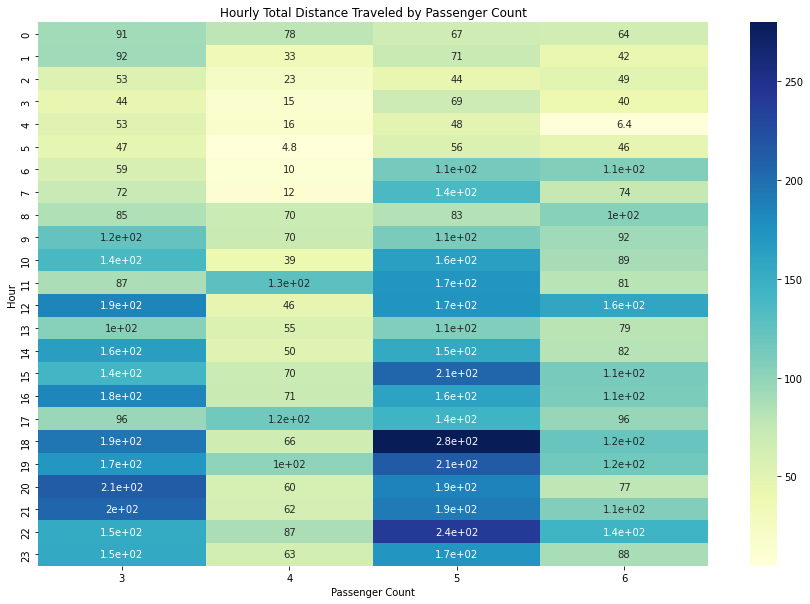

In [68]:
plt.figure(figsize=(15, 10))
distance_per_passenger_count = df[df['passenger_count'] >= 3]
heatmap_data = distance_per_passenger_count.groupby(by=['passenger_count', 'hour']).sum()[['trip_distance']].reset_index().pivot(index='hour', columns='passenger_count', values='trip_distance')
sns.heatmap(heatmap_data, cmap='YlGnBu', annot=True)
plt.title('Hourly Total Distance Traveled by Passenger Count')
plt.xlabel('Passenger Count')
plt.ylabel('Hour')
plt.show()

The analysis delves into the relationship between passenger count and total distance traveled, shedding light on nuanced travel patterns. With single-passenger and two-passenger rides dominating, we infer a propensity for longer trip distances within these groups. To further explore the dynamics of larger groups, the focus shifts to examining the total distance covered by groups ranging from three to six passengers. Notably, groups of three and five passengers emerge as prominent, showcasing increased distances traveled, particularly during the evening hours starting from 5:30 PM. This observation suggests a correlation between larger group sizes and extended travel distances, potentially indicating night activities. Intriguingly, four-passenger groups stand out for covering shorter distances compared to their counterparts, unveiling distinctive travel behaviors within various passenger count categories.

### Temporal Patterns

**Ride Count by Month**

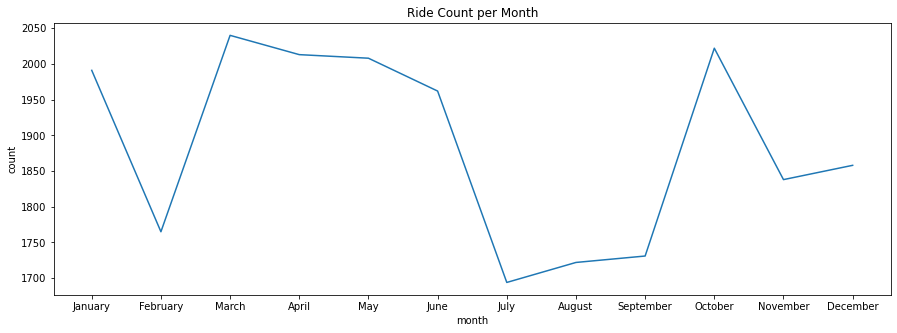

In [69]:
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
monthly_rides = df['month'].value_counts()
monthly_rides = monthly_rides.sort_index()[months]
sns.lineplot(x=monthly_rides.index, y=monthly_rides)
plt.title('Ride Count per Month')
plt.xlabel('month')
plt.ylabel('count')
plt.show()

The histogram illustrates the total ride counts per month in the dataset, providing insights into the temporal distribution of taxi trips in NYC. This breakdown allows us to observe monthly variations in taxi ride demand. The dataset exhibits fluctuations, possibly influenced by seasonal factors, events, or other external factors that impact transportation needs. Monthly rides are fairly consistent, with notable dips in the summer months of July, August, and September, and also in February. Understanding these patterns can contribute to optimizing taxi services and resource allocation throughout the year.

**Ride Count by Day**

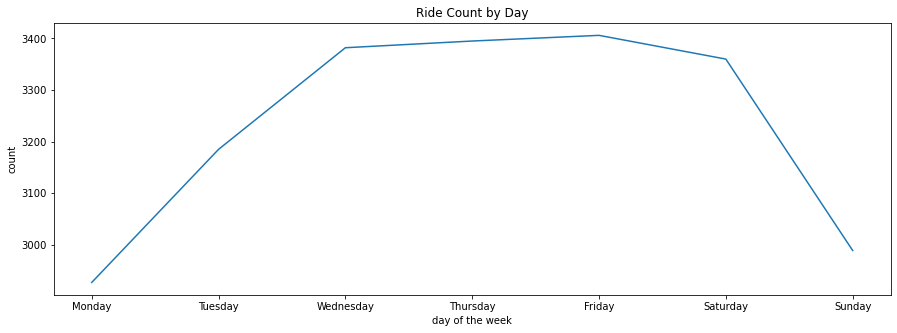

In [70]:
days_of_week = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
ride_by_day = df['day'].value_counts()
ride_by_day = ride_by_day.sort_values()[days_of_week]
sns.lineplot(x=ride_by_day.index, y=ride_by_day)
plt.title('Ride Count by Day')
plt.xlabel('day of the week')
plt.ylabel('count')
plt.show()

The line plot displays the distribution of taxi ride counts by day of the week, providing insights into the weekly demand for taxi services in NYC. This breakdown reveals variations in taxi ride demand throughout the week. Weekdays, particularly Wednesday, Thursday, and Friday, show higher ride counts, reflecting increased transportation needs during business days. Friday has the highest daily ride count, while Sunday and Monday have the fewest. The slightly lower counts on Sundays may indicate a weekend lull in demand. This information can guide strategic decisions related to pricing, promotions, and resource allocation, helping to maximize revenue and optimize operations based on weekly fluctuations in demand.

**Ride Count by Time of Day**

In [71]:
df.groupby(by='time_of_day').count()[['tpep_pickup_datetime']]

,tpep_pickup_datetime
time_of_day,
am_rush,3480
daytime,6750
nighttime,7178
pm_rush,5236


The distribution of taxi rides across different times of the day reveals that daytime experiences the highest demand, with 6,750 rides, followed closely by nighttime with 7,178 rides. The morning rush hour (`am_rush`) and evening rush hour (`pm_rush`) exhibit lower ride counts, indicating lower demand during these specific time frames.

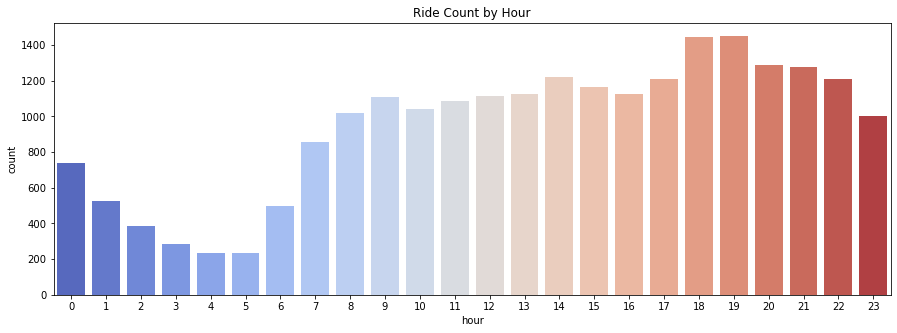

In [72]:
ride_by_hour = df['hour'].value_counts()
sns.barplot(x=ride_by_hour.index, y=ride_by_hour, palette='coolwarm')
plt.title('Ride Count by Hour')
plt.xlabel('hour')
plt.ylabel('count')
plt.show()

The hours 18:00 (6:00 PM) to 20:00 (8:00 PM) emerge as the peak period, with the highest number of rides, indicating a substantial demand during the evening rush hour. Additionally, the hours 20:00 (8:00 PM) to 22:00 (10:00 PM) maintain consistently high ride counts, suggesting sustained demand during the late evening. On the other hand, early morning hours, particularly from 0:00 (12:00 AM) to 6:00 (6:00 AM), exhibit lower ride counts, reflecting reduced demand during these overnight hours. This temporal breakdown can guide strategic decisions related to resource allocation, staffing, and pricing adjustments to maximize efficiency and revenue during peak demand periods.

**Total Revenue by Day of the Week**

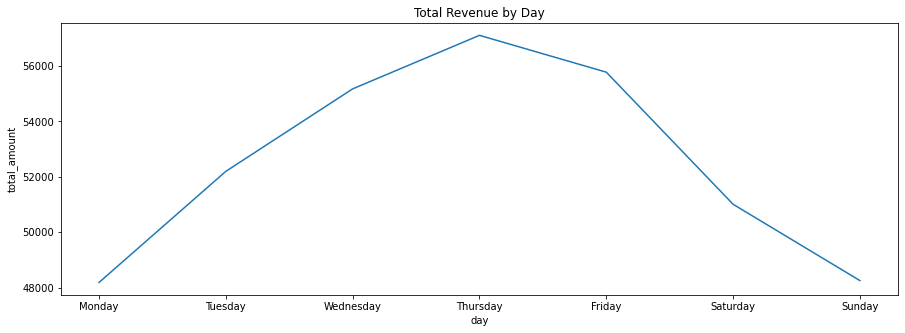

In [73]:
revenue_by_day = df.groupby(by='day').sum()[['total_amount']].reindex(days_of_week)
sns.lineplot(data=revenue_by_day, x=revenue_by_day.index, y='total_amount')
plt.title('Total Revenue by Day')
plt.show()

The breakdown of total revenue by day of the week provides valuable insights into the financial performance of taxi services in NYC. The data indicates variations in revenue across different days, reflecting the dynamic nature of the transportation business. Wednesday and Thursday stand out with the highest total revenue, suggesting increased financial activity during the midweek. The revenue decreases slightly on Friday and over the weekend, with Sunday having the lowest total revenue.

**Total Revenue by Month**

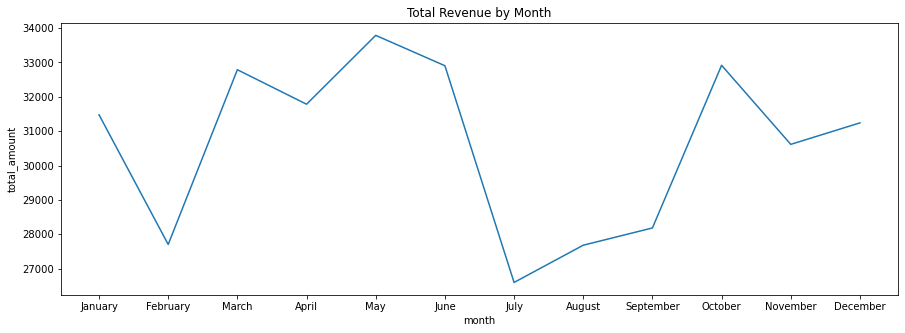

In [74]:
revenue_by_month = df.groupby(by='month').sum()[['total_amount']].reindex(months)
sns.lineplot(data=revenue_by_month, x=revenue_by_month.index, y='total_amount')
plt.title('Total Revenue by Month')
plt.show()

Analyzing the total revenue by month sheds light on the financial trends in taxi services throughout the year in NYC. The data indicates varying revenue levels across different months, providing insights into the seasonal dynamics of the transportation business. March, May and October emerge as the months with the highest total revenue, suggesting potential peak periods for taxi services. In contrast, July and August show lower revenue, possibly reflecting a seasonal dip in demand during the summer months. 

**Influence of Holidays on NYC Taxi Services**

In [75]:
# https://leaveboard.com/public-holidays/united-states-new-york-public-holidays-2017/
df['date'] = df['tpep_pickup_datetime'].dt.date.astype('str')

holiday_data = pd.DataFrame({
    'date': [
        '2017-01-02',
        '2017-01-16',
        '2017-02-13',
        '2017-02-20',
        '2017-05-29',
        '2017-07-04',
        '2017-09-04',
        '2017-10-09',
        '2017-11-07',
        '2017-11-11',
        '2017-11-23',
        '2017-12-25',
    ],
    'holiday': [
        'New Year\'s Day',
        'Dr. Martin Luther King, Jr. Day',
        'Lincoln\'s Birthday',
        'Washington\'s Birthday',
        'Memorial Day',
        'Independence Day',
        'Labor Day',
        'Columbus Day',
        'Election Day',
        'Veterans\' Day',
        'Thanksgiving Day',
        'Christmas Day'
    ]
})

In [76]:
holiday_df = pd.merge(df, holiday_data, on='date', how='inner')
holiday_df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,tip_amount,tolls_amount,total_amount,month,day,hour,time_of_day,season,duration,pickup_dropoff,mean_distance,mean_duration,tip_percent,trip_speed_mph,date,holiday
0,1,2017-02-13 10:29:33,2017-02-13 10:34:11,1,0.90,1,N,237,237,1,5.5,0.0,1.25,0.0,7.55,February,Monday,10,daytime,1,4.63,237 237,0.601667,4.660729,0.198,11.663067,2017-02-13,Lincoln's Birthday
1,1,2017-02-13 16:25:41,2017-02-13 16:55:35,1,4.20,1,N,140,166,2,21.0,1.0,0.00,0.0,22.80,February,Monday,16,pm_rush,1,29.90,140 166,4.200000,29.900000,0.000,8.428094,2017-02-13,Lincoln's Birthday
2,1,2017-02-13 21:13:32,2017-02-13 21:25:26,1,2.40,1,N,263,48,1,11.0,0.5,0.00,0.0,12.30,February,Monday,21,nighttime,1,11.90,263 48,2.963333,17.031667,0.000,12.100840,2017-02-13,Lincoln's Birthday
3,2,2017-02-13 15:44:33,2017-02-13 15:48:14,5,0.60,1,N,164,234,1,4.5,0.0,1.00,0.0,6.30,February,Monday,15,daytime,1,3.68,164 234,0.769032,4.996452,0.189,9.782609,2017-02-13,Lincoln's Birthday
4,2,2017-02-13 21:44:56,2017-02-13 21:54:44,4,1.79,1,N,230,239,1,8.5,0.5,1.96,0.0,11.76,February,Monday,21,nighttime,1,9.80,230 239,1.990000,10.840435,0.200,10.959184,2017-02-13,Lincoln's Birthday


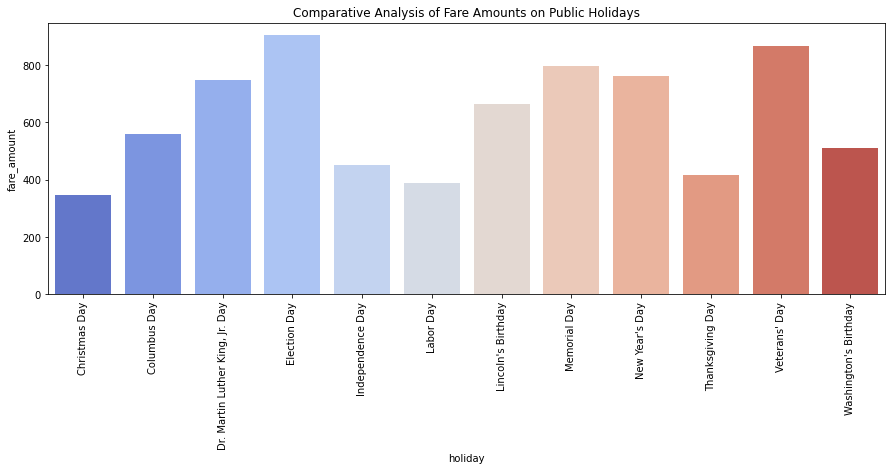

In [77]:
holiday_fares = holiday_df.groupby(by='holiday').sum()[['fare_amount']]
ax = sns.barplot(data=holiday_fares, x=holiday_fares.index, y='fare_amount', palette='coolwarm')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.title('Comparative Analysis of Fare Amounts on Public Holidays')
plt.show()

The fare amounts during public holidays in NYC exhibit interesting patterns, shedding light on the financial aspects of taxi services on these special occasions. Among the holidays analyzed, Election Day stands out with the highest total fare amount, reaching \\$902.50, followed closely by Memorial Day and Dr. Martin Luther King, Jr. Day. These results suggest increased spending on taxi services during these holidays, potentially influenced by specific events, celebrations, or travel patterns.

Conversely, Labor Day and Independence Day show lower total fare amounts, indicating a comparatively subdued demand on these holidays. The variation in fare amounts across different holidays emphasizes the dynamic nature of taxi service economics during public celebrations. This information can guide pricing strategies, promotions, and operational decisions, allowing stakeholders to optimize revenue during peak holiday periods and manage resources efficiently during quieter times.

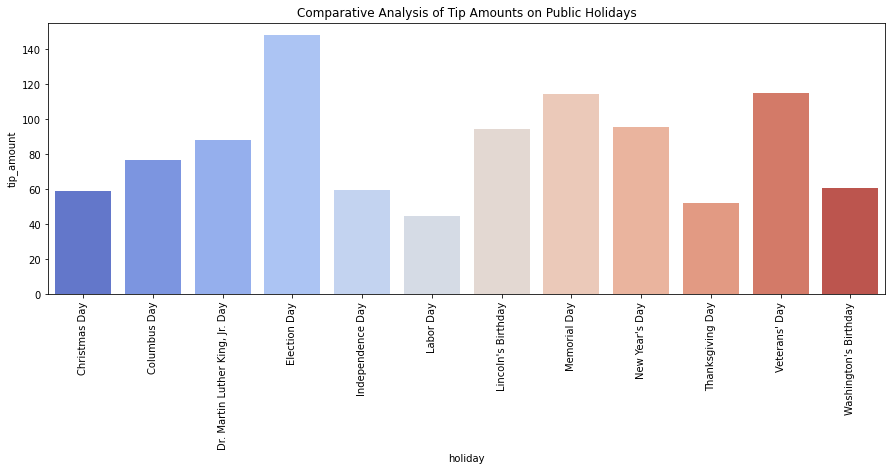

In [78]:
holiday_tips = holiday_df.groupby(by='holiday').sum()[['tip_amount']]
ax = sns.barplot(data=holiday_tips, x=holiday_tips.index, y='tip_amount', palette='coolwarm')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.title('Comparative Analysis of Tip Amounts on Public Holidays')
plt.show()

Election Day stands out with the highest average tip amount, suggesting a willingness among passengers to show appreciation for taxi services during this civic event. Dr. Martin Luther King, Jr. Day and Memorial Day also record relatively high average tip amounts, indicating a positive sentiment and potential gratitude on these holidays. Conversely, Labor Day shows a lower average tip, suggesting that passengers may be less inclined to tip generously during this particular holiday.

### Rate Code Analysis

The final rate code at the end of a trip provides insights into the fare structures used in NYC taxi services. Here's a breakdown of the key rate codes:

1. **Standard Rate (Code 1):** The most common fare structure, representing standard fares for typical taxi rides within the city.

2. **JFK (Code 2):** Indicates trips to or from JFK Airport, with a specific fare arrangement tailored for airport travel.

3. **Newark (Code 3):** Designates trips to or from Newark Airport, featuring a distinct fare structure for journeys involving this airport.

4. **Nassau or Westchester (Code 4):** Covers rides to Nassau or Westchester, each with its unique fare arrangement.

5. **Negotiated Fare (Code 5):** Represents trips with a fare negotiated in advance, allowing flexibility in pricing based on agreements between passengers and drivers.

**Rate Code Distribution**

In [79]:
df['RatecodeID'].value_counts()

1    22029
2      507
5       62
3       38
4        8
Name: RatecodeID, dtype: int64

The majority of the trips fall under the Standard Rate Code (Code 1), reflecting the common use of standard fares for typical city rides. Trips pertaining to or from JFK Airport, is the second most common, highlighting the significance of airport travel.

**Tip Amounts Across NYC Taxi Rate Codes**

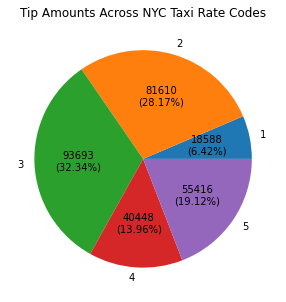

In [80]:
tip_by_ratecode = df.groupby(by='RatecodeID').mean()[['tip_amount']]
plt.pie(data=tip_by_ratecode, x='tip_amount', labels=[1, 2, 3, 4, 5], autopct=lambda p: '{:.0f}\n({:.2f}%)'.format(p * sum(fare_by_payment['fare_amount']) / 100, p))
plt.title('Tip Amounts Across NYC Taxi Rate Codes')
plt.show()

The Mean Tip Amount analysis based on different Rate Codes offers insights into the tipping behavior associated with various fare structures in NYC taxi services. Trips to or from JFK Airport (Code 2) and Newark Airport (Code 3) exhibit higher average tip amounts of \\$7.33 and \\$8.42, respectively. These findings suggest that passengers may be more inclined to provide higher tips for airport-related trips, possibly influenced by factors such as luggage handling or longer travel distances. For Negotiated Fares (Code 5), the mean tip amount is \\$4.98, indicating a moderate tipping behavior for these specific fare agreements. Trips under Code 4 (Nassau or Westchester) and Standard Rate Code (Code 1) have mean tip amounts relatively lower compared to other codes.

### Trip Speed Patterns

**Trip Speeds in NYC Taxi Services**

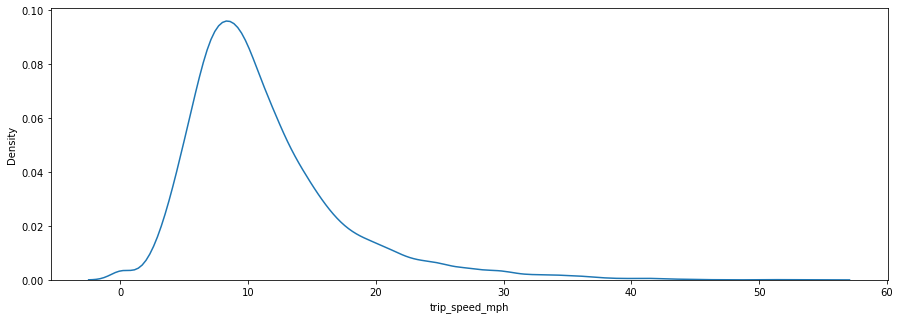

In [81]:
# speed distribution by mph
sns.kdeplot(data=df, x='trip_speed_mph')
plt.show()

The kernel density estimate (KDE) plot reveals a peak around 10 mph, indicating a common speed range for taxi trips. This finding aligns with safe driving practices, as lower speeds within urban areas contribute to overall road safety. The concentration of trip speeds around 10 mph suggests that drivers in our dataset tend to navigate through the city at moderate speeds, fostering a safer environment for both passengers and pedestrians. This insight highlights the commitment to safety within our taxi services, emphasizing responsible driving practices that prioritize the well-being of all road users.

**Average Trip Speeds by Payment Type**

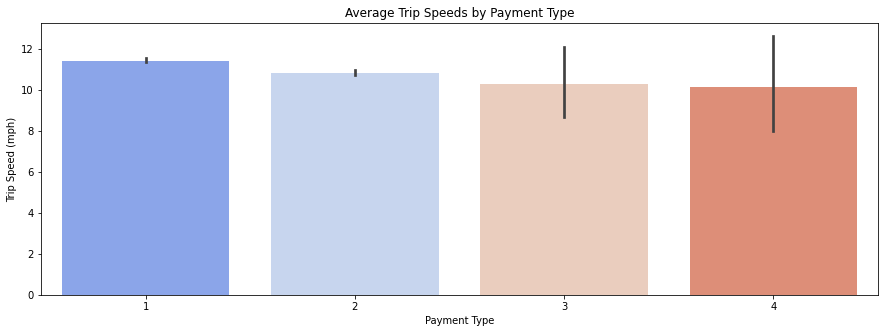

In [82]:
# speed by payment type
sns.barplot(x='payment_type', y='trip_speed_mph', data=df, palette='coolwarm')
plt.title('Average Trip Speeds by Payment Type')
plt.xlabel('Payment Type')
plt.ylabel('Trip Speed (mph)')
plt.show()

The analysis of average trip speeds based on different payment types reveals interesting insights into the efficiency of taxi services. Payment type 1, which predominantly represents credit card payments, exhibits the highest average trip speed above 11 mph. On the other hand, payment types 2, 3, and 4, corresponding to cash, no charge, and disputed payments, respectively, show slightly lower average speeds, ranging around 10 mph. While the differences in average speeds are subtle, they suggest that credit card transactions may be associated with slightly faster trips. This observation could be attributed to the streamlined nature of electronic payments, contributing to a more efficient and time-effective transaction process.

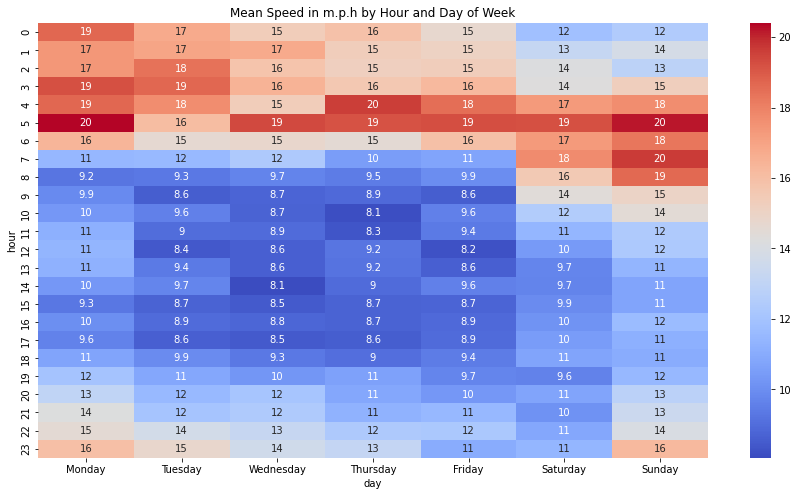

In [83]:
plt.figure(figsize=(15, 8))
heatmap_data = df.pivot_table(index='hour', columns='day', values='trip_speed_mph', aggfunc='mean')
heatmap_data = heatmap_data[days_of_week]
sns.heatmap(data=heatmap_data, annot=True, cmap='coolwarm')
plt.title('Mean Speed in m.p.h by Hour and Day of Week')
plt.show()

### Correlation Analysis

**Correlation Between Fare Amount, Mean Duration and Mean Distance**

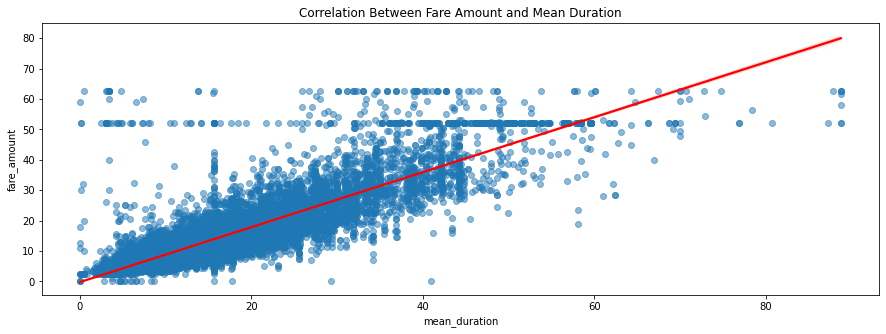

In [84]:
sns.regplot(data=df, x='mean_duration', y='fare_amount', line_kws={'color': 'red'}, scatter_kws={'alpha': 0.5})
plt.title('Correlation Between Fare Amount and Mean Duration')
plt.show()

In [85]:
df[df['fare_amount'] >= 50]['fare_amount'].value_counts().head()

52.0    508
62.5     79
50.5      9
57.5      8
59.0      8
Name: fare_amount, dtype: int64

In [86]:
df[df['fare_amount'] == 52].head(30)

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,tip_amount,tolls_amount,total_amount,month,day,hour,time_of_day,season,duration,pickup_dropoff,mean_distance,mean_duration,tip_percent,trip_speed_mph,date
11,2,2017-03-05 19:15:30,2017-03-05 19:52:18,2,18.90,2,N,236,132,1,52.0,0.0,14.58,5.54,72.92,March,Sunday,19,pm_rush,2,36.80,236 132,19.211667,40.496667,0.250,30.815217,2017-03-05
110,1,2017-06-03 14:24:57,2017-06-03 15:31:48,1,18.00,2,N,132,163,1,52.0,0.0,0.00,0.00,52.80,June,Saturday,14,daytime,3,66.85,132 163,19.229000,52.943000,0.000,16.155572,2017-06-03
161,2,2017-11-11 20:16:16,2017-11-11 20:17:14,1,0.23,2,N,132,132,2,52.0,0.0,0.00,0.00,52.80,November,Saturday,20,nighttime,4,0.97,132 132,2.255862,3.022414,0.000,14.226804,2017-11-11
247,2,2017-12-06 23:37:08,2017-12-07 00:06:19,1,18.93,2,N,132,79,2,52.0,0.0,0.00,0.00,52.80,December,Wednesday,23,nighttime,1,29.18,132 79,19.431667,47.273333,0.000,38.923920,2017-12-06
379,2,2017-09-24 23:45:45,2017-09-25 00:15:14,1,17.99,2,N,132,234,1,52.0,0.0,14.64,5.76,73.20,September,Sunday,23,nighttime,4,29.48,132 234,17.654000,49.834000,0.250,36.614654,2017-09-24
388,1,2017-02-28 18:30:05,2017-02-28 19:09:55,1,18.40,2,N,132,48,2,52.0,4.5,0.00,5.54,62.84,February,Tuesday,18,pm_rush,1,39.83,132 48,18.761905,58.244762,0.000,27.717801,2017-02-28
406,2,2017-06-05 12:51:58,2017-06-05 13:07:35,1,4.73,2,N,228,88,2,52.0,0.0,0.00,5.76,58.56,June,Monday,12,daytime,3,15.62,228 88,4.730000,15.620000,0.000,18.169014,2017-06-05
449,2,2017-08-03 22:47:14,2017-08-03 23:32:41,2,18.21,2,N,132,48,2,52.0,0.0,0.00,5.76,58.56,August,Thursday,22,nighttime,3,45.45,132 48,18.761905,58.244762,0.000,24.039604,2017-08-03
468,2,2017-09-26 13:48:26,2017-09-26 14:31:17,1,17.27,2,N,186,132,2,52.0,0.0,0.00,5.76,58.56,September,Tuesday,13,daytime,4,42.85,186 132,17.096000,42.922000,0.000,24.182030,2017-09-26
520,2,2017-04-23 21:34:48,2017-04-23 22:46:23,6,18.34,2,N,132,148,1,52.0,0.0,5.00,0.00,57.80,April,Sunday,21,nighttime,2,71.58,132 148,17.994286,46.340000,0.095,15.373009,2017-04-23


The regression plot illustrates a positive correlation between `fare_amount` and `mean_duration`, indicating that longer trip durations are associated with higher fare amounts. Notably, anomalies in the data are observed, represented by horizontal lines. Upon investigation, it is identified that these anomalies correspond to a flat fare of \\$52, specifically associated with `PULocation 132` and `RatecodeID` of 2. This suggests that this location is likely an airport, as indicated by frequent toll amounts. This hypothesis can be further confirmed by information provided in the data dictionary, which indicates the known rate for taxi trips between JFK Airport and Manhattan. Additionally, there are several data points of \\$62.50, which is the maximum amount imputed by the outliers. These anomalies are justifiable, aligning with the flat fare policy for JFK trips during the data collection period. Moving forward, the imputation of `RatecodeID` values back into the data after model predictions ensures the correctness of these specific data points.

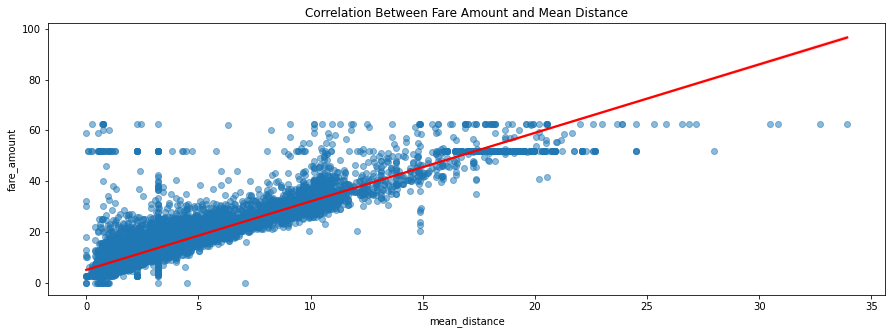

In [87]:
sns.regplot(data=df, x='mean_distance', y='fare_amount', line_kws={'color': 'red'}, scatter_kws={'alpha': 0.5})
plt.title('Correlation Between Fare Amount and Mean Distance')
plt.show()

In the regression plot depicting the correlation between `fare_amount` and `mean_distance`, the tightly condensed data points around the regression line indicate a strong correlation between the distance of the trip and the resulting fare amount. This suggests that, on average, longer distances are associated with higher fare amounts, and vice versa.

The presence of horizontal lines in the graph, similar to the anomalies observed in the plot for correlation between `mean_duration` and `fare_amount`, indicates instances where a flat fare of \\$52 is applied. Further investigation reveals that these anomalies are associated with a specific location (`PULocation 132`) and a `RatecodeID` of 2, signifying trips to and from JFK Airport. This aligns with the flat fare policy for JFK trips during the data collection period.

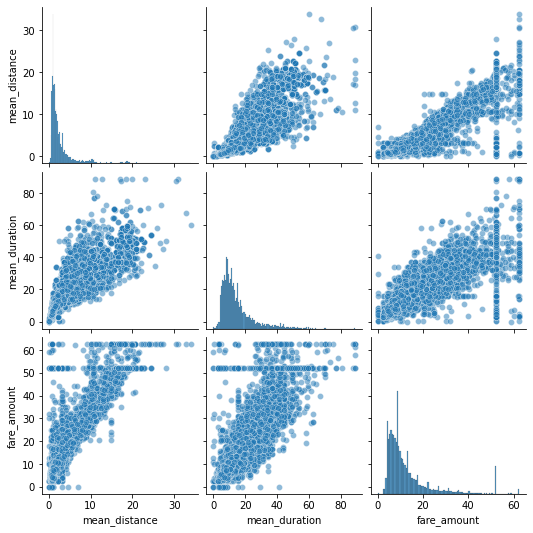

In [88]:
corr_df = df[['mean_distance', 'mean_duration', 'fare_amount']]
sns.pairplot(data=corr_df, plot_kws={'alpha': 0.5})
plt.show()

### Model Feature Exploration

**Tipping Behaviour**

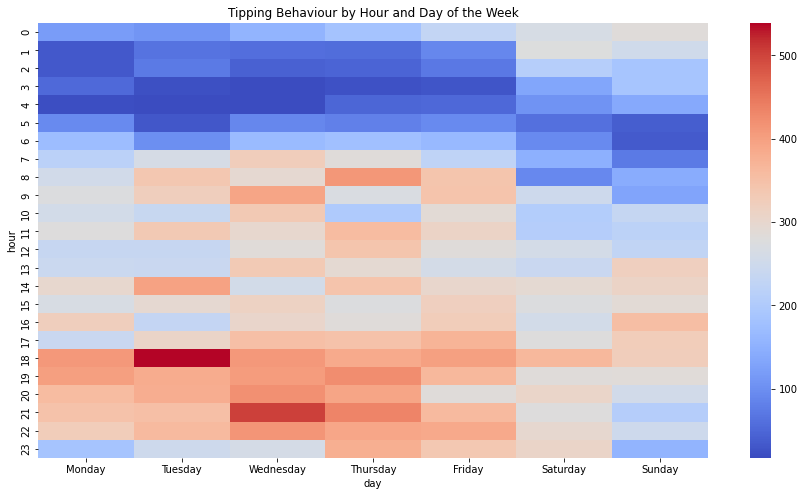

In [89]:
heatmap_data = df.pivot_table(index='hour', columns='day', values='tip_amount', aggfunc='sum')
heatmap_data = heatmap_data[days_of_week]

plt.figure(figsize=(15, 8))
sns.heatmap(data=heatmap_data, cmap='coolwarm')
plt.title('Tipping Behaviour by Hour and Day of the Week')
plt.show()

The heatmap illustrates distinct patterns in tipping behavior by hour and day of the week. Notably, late evening hours from 7 PM to 10 PM consistently exhibit higher tip amounts, indicating passengers' increased propensity to tip during these evening hours, potentially influenced by longer or more enjoyable rides. 

On weekdays, there is a general trend of rising tip amounts from morning to evening, with peaks during late evening hours. Mondays and Tuesdays show a dip in tip amounts during the afternoon, while Wednesdays and Thursdays display a gradual increase throughout the day. Fridays stand out with a significant peak in late evening tips, signaling a higher likelihood of tips at the start of the weekend. 

Saturdays consistently maintain high tip amounts throughout the day, while Sundays, though also displaying elevated tips in the evening, exhibit slightly lower tip amounts during the afternoon compared to Saturdays. This analysis provides valuable insights into the nuanced tipping behavior, enabling a deeper understanding of passenger preferences across different days and hours.

**Total Revenue by Season**

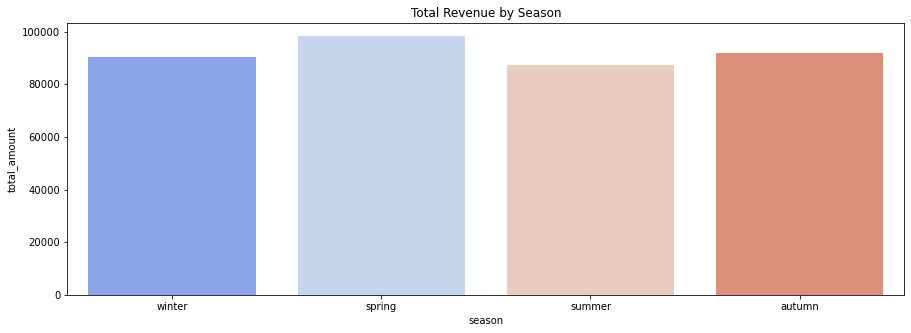

In [90]:
revenue_by_season = df.groupby(by='season').sum()[['total_amount']]
ax = sns.barplot(data=revenue_by_season, x=revenue_by_season.index, y='total_amount', palette='coolwarm')
ax.set_xticklabels(['winter', 'spring', 'summer', 'autumn'])
plt.title('Total Revenue by Season')
plt.show()

The analysis of total revenue by seasonality reveals interesting patterns in the taxi service's financial performance. The spring season emerges as a peak period, experiencing the highest total revenue from fares. This observation suggests a possible surge in taxi demand or adjustments in pricing strategies during this season. Conversely, the summer season shows a dip in total revenue, signaling a period of lower demand or potentially altered travel patterns. The winter and autumn seasons exhibit comparable revenue figures, indicating stability in service utilization. Understanding these patterns can aid in strategic decision-making, such as optimizing resource allocation or adjusting pricing strategies during peak seasons.

Typically, the seasons with the highest average rainfall in New York City are spring and summer. During these periods, especially from March to June, increased precipitation, including rain, is observed. Warmer temperatures and higher humidity characterize these seasons, creating conditions conducive to precipitation. A [study](https://www.sciencedirect.com/science/article/abs/pii/S0167268118301598) have established a significant correlation between the number of taxi rides and rainfall. The findings indicate that as the frequency of rain increases, so does the demand for personal transportation. This logical connection aligns with the observed patterns in taxi service revenue, where the spring season, known for heightened rainfall, coincides with increased taxi demand. It underscores the influence of weather conditions on transportation preferences, with individuals opting for taxis during inclement weather for convenience and comfort.

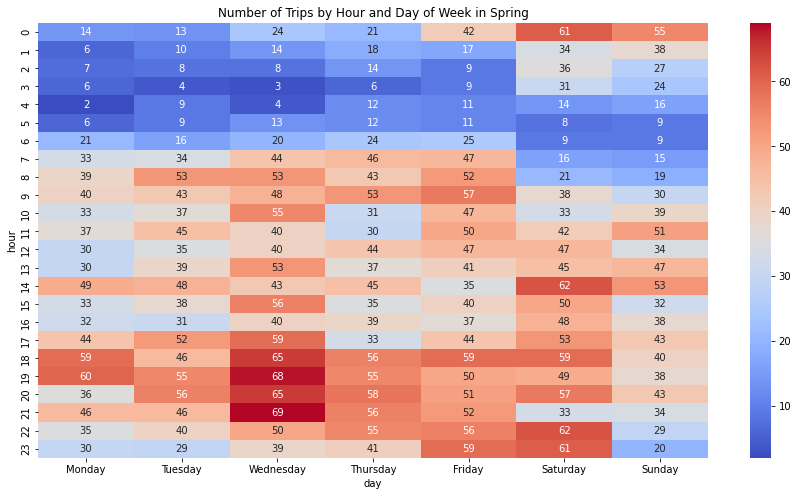

In [91]:
spring_df = df[df['season'] == 2]
heatmap_data = spring_df.pivot_table(index='hour', columns='day', values='tpep_pickup_datetime', aggfunc='count')
heatmap_data = heatmap_data[days_of_week]

plt.figure(figsize=(15, 8))
sns.heatmap(data=heatmap_data, annot=True, cmap='coolwarm')
plt.title('Number of Trips by Hour and Day of Week in Spring')
plt.show()

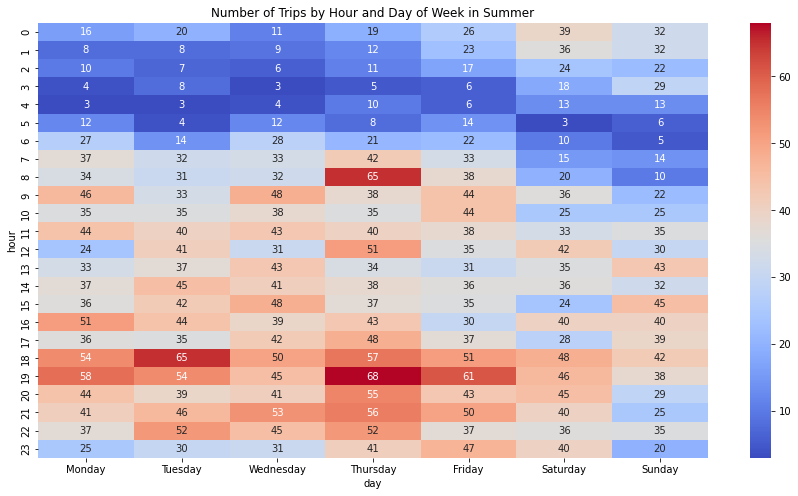

In [92]:
summer_df = df[df['season'] == 3]
heatmap_data = summer_df.pivot_table(index='hour', columns='day', values='tpep_pickup_datetime', aggfunc='count')
heatmap_data = heatmap_data[days_of_week]

plt.figure(figsize=(15, 8))
sns.heatmap(data=heatmap_data, annot=True, cmap='coolwarm')
plt.title('Number of Trips by Hour and Day of Week in Summer')
plt.show()

In comparing the heatmaps between spring and summer, distinctive patterns emerge, particularly during the evenings. Both seasons exhibit heightened activity during these hours, indicating increased demand for taxi rides. However, a closer examination reveals notable differences, especially on specific weekdays.

During spring, Wednesdays, Fridays, and Saturdays stand out with significantly higher ride counts compared to other weekdays. This suggests a distinct weekly pattern, possibly influenced by factors such as midweek outings and weekend events. In contrast, the summer heatmap depicts a more consistent distribution of ride counts throughout the weekdays. The fluctuations observed in spring are less apparent, indicating a more uniform demand for taxi services during summer weekdays. These findings highlight the seasonal nuances in taxi ride patterns, showcasing the impact of weekdays on ride demand.

**Mean Trip Distance by Drop-off Location**

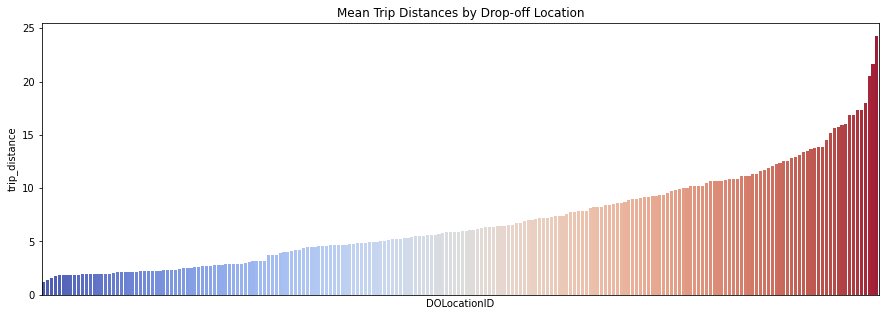

In [93]:
loc_mean_dist = df.groupby(by='DOLocationID').mean()[['trip_distance']]
loc_mean_dist = loc_mean_dist.sort_values('trip_distance')
ax = sns.barplot(data=loc_mean_dist, x=loc_mean_dist.index, y='trip_distance', palette='coolwarm', order=loc_mean_dist.index)
ax.set_xticks([])
plt.title('Mean Trip Distances by Drop-off Location')
plt.show()

This plot illustrates a characteristic curve associated with the cumulative density function of a normal distribution. In simpler terms, it indicates that the drop-off points are relatively evenly distributed across the terrain. This information is valuable because geographic coordinates were not included in this dataset, making it challenging to assess the distribution of locations directly.

## Fare-Payment A/B Analysis for Revenue Optimization

In pursuit of revenue optimization within the taxi service domain, our objective is to delve into the nuanced relationship between total fare amounts and distinct payment types. Adopting a strategic approach, we will conduct A/B testing coupled with hypothesis analysis to uncover insights into the dynamics of fare amounts and their correlation with various payment methods. This systematic exploration aims to not only enhance our understanding of revenue generation but also to inform targeted strategies for maximizing profitability within the taxi service ecosystem.

In [94]:
df.groupby(by='payment_type').mean()[['fare_amount']]

,fare_amount
payment_type,
1,13.251361
2,12.107912
3,12.376330
4,13.465909


In examining the mean fare amounts across different payment types, a preliminary analysis indicates that customers using credit cards tend to incur slightly higher average fare amounts compared to those opting for cash payments. To assess the significance of this observed difference, a hypothesis test is underway. The null hypothesis ($H_0$) posits that there is no discernible distinction in average fares between credit card and cash transactions, while the alternative hypothesis ($H_A$) suggests otherwise. Employing a two-sample t-test with a chosen significance level of 5%, this statistical analysis will provide insights into whether the observed variations are statistically significant or could be attributed to random sampling. The outcome will contribute to a nuanced understanding of the impact of payment methods on fare amounts, informing strategic decisions for revenue optimization within our taxi service framework.

In [95]:
credit_card = df[df['payment_type'] == 1]['fare_amount']
cash = df[df['payment_type'] == 2]['fare_amount']
stats.ttest_ind(a=credit_card, b=cash, equal_var=False)

Ttest_indResult(statistic=7.811085976146681, pvalue=6.046251621300095e-15)

The results of the two-sample t-test reveal a statistically significant difference in average fare amounts between customers using credit cards and those opting for cash payments. With a remarkably low p-value of approximately 6.05e-15, well below the chosen significance level of 5%, we confidently reject the null hypothesis. This implies that there is a meaningful distinction in fare amounts based on the chosen payment method. This statistical insight presents opportunities for revenue optimization within our taxi service framework. Encouraging customers to choose credit card payments may be a strategic avenue for generating higher revenues, opening possibilities for tailored incentives or promotions. 

While our analysis indicates a significant difference in average fare amounts between credit card and cash payments, it's crucial to acknowledge the inherent complexity in interpreting causation. We assumed a unidirectional relationship where payment type influences fare amounts. However, real-world dynamics may involve a bidirectional influence, with fare amounts potentially influencing payment choices. For instance, riders opting for longer or costlier trips may naturally lean towards credit card payments due to convenience or financial considerations. This nuanced perspective suggests that the observed payment differences could be a result of fare amounts influencing payment type, rather than a direct impact of payment type on fare amounts. This insight prompts a more holistic exploration of passenger behavior, considering factors beyond a unidirectional relationship between payment choices and fare amounts.

## Build a Multiple Linear Regression Model

In the pursuit of understanding and optimizing the factors influencing taxi fare amounts, we are embarking on the construction of a Multiple Linear Regression model. This powerful statistical tool enables us to unravel the intricate interplay between various independent variables, and their collective impact on the continuous dependent variable (`fare_amount`). By harnessing the predictive capabilities of this model, we aim to discover the relationships that contribute to fare variations, providing valuable insights for taxi service providers. This analytical endeavor serves as a pivotal step in our commitment to enhancing decision-making processes and fostering a deeper understanding of the complex dynamics within the NYC taxi industry.

### Feature Engineering

Building on the valuable insights gleaned from our thorough exploratory data analysis, we are poised to implement a new feature that encapsulates the essence of rush hours in the context of NYC taxi rides. Recognizing the significance of commuting patterns and heightened demand during specific timeframes, we will define `rush_hour` as encompassing any weekday falling between 6 AM to 10 AM and 4 PM to 8 PM. To operationalize this concept, we will introduce a binary `rush_hour` column, taking the value `1` if the ride occurs during these peak periods and `0` otherwise.

In [96]:
# if day is Saturday or Sunday, impute 0 in `rush_hour` column
df['rush_hour'] = df['tpep_pickup_datetime'].copy
df.loc[df['day'].isin(['Saturday', 'Sunday']), 'rush_hour'] = 0

In [97]:
def rush_hourizer(hr):
    df.loc[((hr >= 6) & (hr < 10) | (hr >= 16) & (hr < 20)) & (df['rush_hour'] != 0), 'rush_hour'] = 1
    df.loc[(df['rush_hour'] != 0) & (df['rush_hour'] != 1), 'rush_hour'] = 0

In [98]:
rush_hourizer(df['tpep_pickup_datetime'].dt.hour)
df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,tip_amount,tolls_amount,total_amount,month,day,hour,time_of_day,season,duration,pickup_dropoff,mean_distance,mean_duration,tip_percent,trip_speed_mph,date,rush_hour
0,2,2017-03-25 08:55:43,2017-03-25 09:09:47,6,3.34,1,N,100,231,1,13.0,0.0,2.76,0.0,16.56,March,Saturday,8,am_rush,2,14.07,100 231,3.521667,22.848333,0.200,14.243070,2017-03-25,0
1,1,2017-04-11 14:53:28,2017-04-11 15:19:58,1,1.80,1,N,186,43,1,16.0,0.0,4.00,0.0,20.80,April,Tuesday,14,daytime,2,26.50,186 43,3.108889,24.470000,0.238,4.075472,2017-04-11,0
2,1,2017-12-15 07:26:56,2017-12-15 07:34:08,1,1.00,1,N,262,236,1,6.5,0.0,1.45,0.0,8.75,December,Friday,7,am_rush,1,7.20,262 236,0.881429,7.250286,0.199,8.333333,2017-12-15,1
3,2,2017-05-07 13:17:59,2017-05-07 13:48:14,1,3.70,1,N,188,97,1,20.5,0.0,6.39,0.0,27.69,May,Sunday,13,daytime,2,30.25,188 97,3.700000,30.250000,0.300,7.338843,2017-05-07,0
4,2,2017-04-15 23:32:20,2017-04-15 23:49:03,1,4.37,1,N,4,112,2,16.5,0.5,0.00,0.0,17.80,April,Saturday,23,nighttime,2,16.72,4 112,4.435000,14.620000,0.000,15.681818,2017-04-15,0


### Isolate Modeling Variables

In [99]:
mlr_df = df.copy()

In [100]:
mlr_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22644 entries, 0 to 22698
Data columns (total 28 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   VendorID               22644 non-null  int64         
 1   tpep_pickup_datetime   22644 non-null  datetime64[ns]
 2   tpep_dropoff_datetime  22644 non-null  datetime64[ns]
 3   passenger_count        22644 non-null  int64         
 4   trip_distance          22644 non-null  float64       
 5   RatecodeID             22644 non-null  int64         
 6   store_and_fwd_flag     22644 non-null  object        
 7   PULocationID           22644 non-null  int64         
 8   DOLocationID           22644 non-null  int64         
 9   payment_type           22644 non-null  int64         
 10  fare_amount            22644 non-null  float64       
 11  extra                  22644 non-null  float64       
 12  tip_amount             22644 non-null  float64       
 13  t

In [101]:
mlr_df = mlr_df.drop([
    'tpep_pickup_datetime', 'tpep_dropoff_datetime', 'mean_distance', 'RatecodeID', 'store_and_fwd_flag', 'PULocationID', \
    'DOLocationID', 'payment_type', 'extra', 'tip_amount', 'tolls_amount', 'total_amount', 'month', 'day', 'hour', \
    'time_of_day', 'season', 'mean_duration', 'pickup_dropoff', 'tip_percent', 'trip_speed_mph', 'date'], 
    axis=1)

In [102]:
mlr_df.head()

,VendorID,passenger_count,trip_distance,fare_amount,duration,rush_hour
0,2,6,3.34,13.0,14.07,0
1,1,1,1.80,16.0,26.50,0
2,1,1,1.00,6.5,7.20,1
3,2,1,3.70,20.5,30.25,0
4,2,1,4.37,16.5,16.72,0


### Identify Correlations

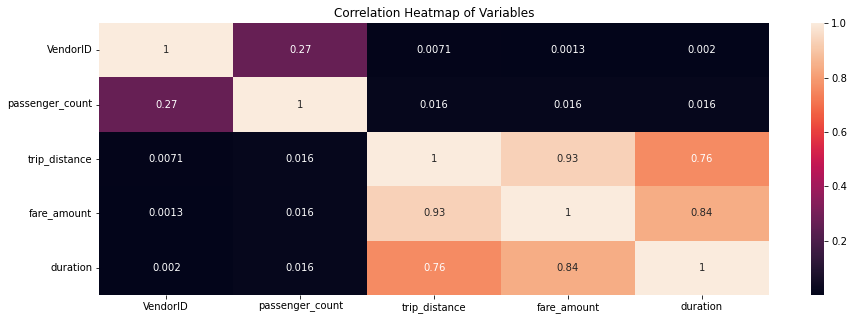

In [103]:
corr = mlr_df.corr(method='pearson')
sns.heatmap(data=corr, annot=True)
plt.title('Correlation Heatmap of Variables')
plt.show()

The correlation analysis reveals interesting insights within the variables of our multiple linear regression model. The moderate positive correlation (0.27) between `VendorID` and `passenger_count` suggests that larger passenger groups tend to opt for Vendor ID 2, indicating potential preferences based on group size. The correlation coefficients between `VendorID` and other variables are generally close to zero, indicating weak linear relationships, emphasizing the independence of Vendor ID from other predictors.

The strong positive correlation (0.93) between `trip_distance` and `fare_amount` aligns with expectations, highlighting that longer distances lead to higher fare amounts. Additionally, the robust positive correlations of `duration` with both `fare_amount` (0.84) and `trip_distance` (0.76) signify that fare amounts increase significantly with both longer distances and durations. While high correlations between predictor variables can pose challenges for linear regression, these strong relationships are valuable for accurately predicting fare amounts when the prediction itself takes precedence over using the model as a tool for data exploration.

### Split Data into Outcome Variable and Features

In [104]:
X = mlr_df.drop(columns='fare_amount')
X.head()

,VendorID,passenger_count,trip_distance,duration,rush_hour
0,2,6,3.34,14.07,0
1,1,1,1.80,26.50,0
2,1,1,1.00,7.20,1
3,2,1,3.70,30.25,0
4,2,1,4.37,16.72,0


In [105]:
y = mlr_df['fare_amount']
y.head()

0    13.0
1    16.0
2     6.5
3    20.5
4    16.5
Name: fare_amount, dtype: float64

### Variable Encoding

In [106]:
X['VendorID'] = X['VendorID'].astype(str)
X['VendorID'] = pd.get_dummies(X['VendorID'], drop_first=True)
X['VendorID'].head()

0    1
1    0
2    0
3    1
4    1
Name: VendorID, dtype: uint8

### Split Data into Training and Testing Sets

In [107]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Standardize Data

In [108]:
scaler = StandardScaler()

In [109]:
X_train_scaled = scaler.fit(X_train).transform(X_train)

### Fit the Model

In [110]:
lr = LinearRegression()

In [111]:
lr.fit(X_train_scaled, y_train)

LinearRegression()

### Evaluate MLR Model

**Train Data**

In [112]:
lr_pred = lr.predict(X=X_train_scaled)

In [113]:
print(f'r2: {r2_score(y_true=y_train, y_pred=lr_pred)}')
print(f'mae: {mean_absolute_error(y_true=y_train, y_pred=lr_pred)}')
print(f'mse: {mean_squared_error(y_true=y_train, y_pred=lr_pred)}')
print(f'rmse: {np.sqrt(mean_squared_error(y_true=y_train, y_pred=lr_pred))}')

r2: 0.9020665917352045
mae: 1.0320667073223175
mse: 10.745516223505174
rmse: 3.2780354213316816


**Test Data**

In [114]:
X_test_scaled = scaler.transform(X_test)

In [115]:
lr_pred_test = lr.predict(X=X_test_scaled)

In [116]:
print(f'r2: {r2_score(y_true=y_test, y_pred=lr_pred_test)}')
print(f'mae: {mean_absolute_error(y_true=y_test, y_pred=lr_pred_test)}')
print(f'mse: {mean_squared_error(y_true=y_test, y_pred=lr_pred_test)}')
print(f'rmse: {np.sqrt(mean_squared_error(y_true=y_test, y_pred=lr_pred_test))}')

r2: 0.93145908276846
mae: 0.9805456657380089
mse: 7.629293833645998
rmse: 2.7621176357363924


The performance metrics for our linear regression model on both the training and testing sets indicate a robust and well-generalizing model. Contrary to overfitting, the test scores outperform the training scores, suggesting that the model effectively captures underlying patterns without introducing bias. The R-squared values, approaching 1, signify the model's ability to explain a significant portion of the variance in the target variable, demonstrating its predictive power. The low MAE values underscore the model's accuracy in predicting fare amounts on both training and testing sets. Notably, the lower MSE on the testing set compared to the training set highlights the model's strong generalization to new data. The diminished RMSE on the testing set further emphasizes the model's precision in predicting fare amounts for previously unseen data. In summary, our model displays consistent, low error metrics, affirming its reliability and proficiency in delivering accurate fare predictions.

**Visualizations**

In [117]:
actual = y_test
predicted = lr_pred_test
residual = y_test - lr_pred_test
results = pd.DataFrame({'actual': actual, 'predicted': predicted, 'residual': residual})
results.head()

,actual,predicted,residual
20343,6.0,6.694346,-0.694346
5183,11.5,10.448038,1.051962
15587,12.5,11.853698,0.646302
15678,10.5,10.116091,0.383909
12397,7.0,8.041636,-1.041636


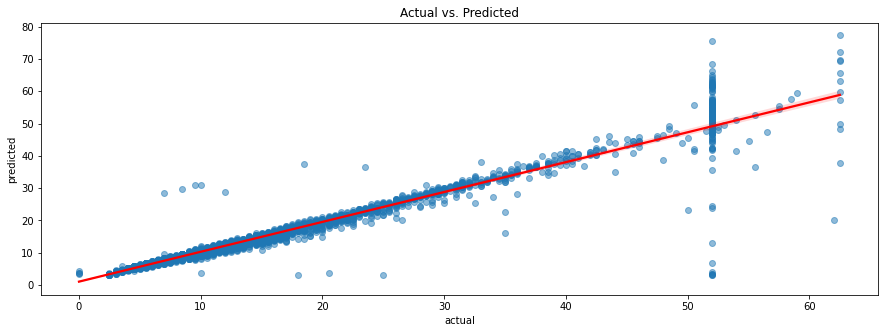

In [118]:
sns.regplot(data=results, x='actual', y='predicted', line_kws={'color': 'red'}, scatter_kws={'alpha': 0.5})
plt.title('Actual vs. Predicted')
plt.show()

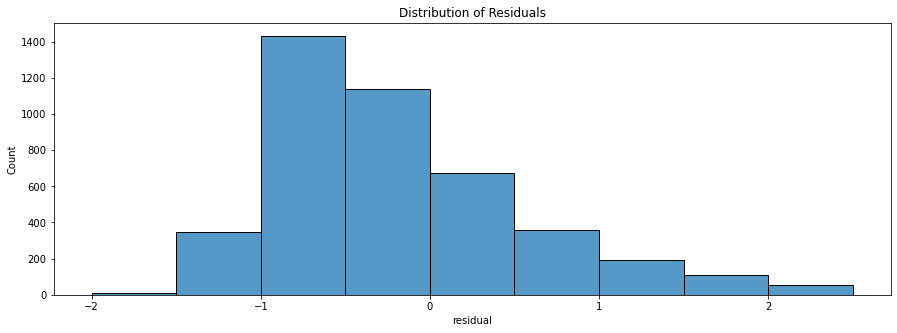

In [119]:
ax = sns.histplot(data=results, x='residual', bins=np.arange(-2, 3, 0.5))
plt.title('Distribution of Residuals')
plt.show()

In [120]:
results['residual'].mean()

-0.03651443273909086

The mean residual value of approximately -0.0365 suggests a slight underestimation bias in the model's predictions. On average, the predicted fare amounts tend to be slightly lower than the actual fare amounts.

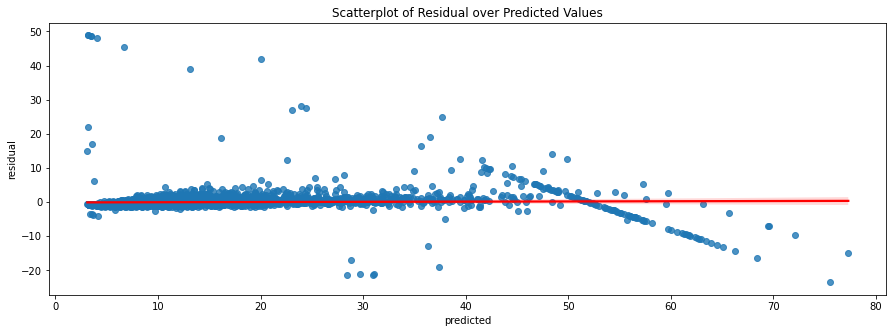

In [121]:
sns.regplot(data=results, x='predicted', y='residual', line_kws={'color': 'red'})
plt.title('Scatterplot of Residual over Predicted Values')
plt.show()

The scatterplot of residuals over predicted values visually confirms that the model's residuals are relatively evenly distributed around zero, indicating that the model is making unbiased predictions on average. However, the observed sloping lines from the upper-left corner to the lower-right corner suggest a pattern associated with specific fare amounts. These lines likely correspond to the imputed maximum fare of \\$62.50 and the flat rate of \\$52 for JFK airport trips. The model struggles to accurately predict fare amounts exceeding \\$52, leading to these systematic errors.

**Coefficients**

In [122]:
coefficients = pd.DataFrame(data=lr.coef_, index=X.columns).transpose()
coefficients

,VendorID,passenger_count,trip_distance,duration,rush_hour
0,-0.041902,0.014792,7.302474,3.195262,-0.000049


The coefficients obtained from the linear regression model provide valuable insights into the relationship between predictor variables and the target variable (`fare_amount`). Among these coefficients, `trip_distance` emerges as the most influential feature in determining fare amounts. Specifically, when controlling for other variables, a one-unit change in `trip_distance` corresponds to an average increase of approximately \\$7.30 in the fare amount. However, it is important to note that due to the presence of highly correlated features that were not removed, the confidence interval associated with this assessment may be wider, influencing the precision of the estimate.

To enhance the interpretability of this finding, we can further translate it into a real-world context by considering the standard deviation of `trip_distance` in the `X_train` data. By calculating the standard deviation and dividing the coefficient (7.301546) by this result, we can obtain a more intuitive interpretation of the impact of trip distance on fare amounts in terms of miles.

In [123]:
print(f"std: {X_train['trip_distance'].std()}")
print(7.301546 / X_train['trip_distance'].std())

std: 3.6435994203481012
2.0039376335454646


The standard deviation of `trip_distance` in the training data is approximately 3.64 miles. Therefore, we can interpret the coefficient of `trip_distance` as follows: for every 3.64 miles traveled, the fare increases by a mean of \\$7.30. Alternatively, expressed in a more granular manner, for every 1 mile traveled, the fare increases by a mean of \\$2.00. This interpretation provides stakeholders with a practical understanding of the relationship between trip distance and fare amounts, offering insights that can be utilized for fare optimization strategies in the taxi service.

**Acknowledgments**

This project is inspired by the [Google Advanced Data Analytics Professional Certificate](https://www.coursera.org/professional-certificates/google-advanced-data-analytics) program, specifically the end-of-course portfolio project titled *Automatidata*.

This project utilises a subset of the [2017 Yellow Taxi Trip Data](https://data.cityofnewyork.us/Transportation/2017-Yellow-Taxi-Trip-Data/biws-g3hs) obtained from the New York City Taxi & Limousine Commission, originally published as part of the NYC Open Data program. The dataset, containing 22,699 rows representing different trips and 18 columns, was provided by the Google Advanced Data Analytics Professional Certificate program for the purpose of the end-of-course portfolio project. Invaluable insights into the dataset's attributes and their meanings were derived from the detailed [Data Dictionary](https://data.cityofnewyork.us/api/views/biws-g3hs/files/eb3ccc47-317f-4b2a-8f49-5a684b0b1ecc?download=true&filename=data_dictionary_trip_records_yellow.pdf) provided by the New York City Taxi & Limousine Commission. We acknowledge the contribution of both the NYC TLC and the Google program to the dataset used in this analysis.